In [81]:
#!pip install kagglehub

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import *
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, Birch, MiniBatchKMeans, SpectralBiclustering, SpectralClustering
from sklearn.decomposition import PCA
import math

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load a DataFrame with a specific version of a CSV
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "tanishksharma9905/top-popular-anime",
    "popular_anime.csv",
)
df

,id,name,genres,type,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,rating,studios,producers,image,trailer,synopsis
0,52991,Frieren: Beyond Journey's End,"Adventure, Drama, Fantasy",TV,28.0,Finished Airing,2023-09-29T00:00:00+00:00,2024-03-22T00:00:00+00:00,24 min per ep,9.30,676737.0,1.0,PG-13 - Teens 13 or older,Madhouse,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",https://cdn.myanimelist.net/images/anime/1015/...,https://www.youtube.com/watch?v=ZEkwCGJ3o7M,During their decade-long quest to defeat the D...
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy",TV,64.0,Finished Airing,2009-04-05T00:00:00+00:00,2010-07-04T00:00:00+00:00,24 min per ep,9.10,2223666.0,2.0,R - 17+ (violence & profanity),Bones,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",https://cdn.myanimelist.net/images/anime/1208/...,https://www.youtube.com/watch?v=1ac3_YdSSy0,After a horrific alchemy experiment goes wrong...
2,9253,Steins;Gate,"Drama, Sci-Fi, Suspense",TV,24.0,Finished Airing,2011-04-06T00:00:00+00:00,2011-09-14T00:00:00+00:00,24 min per ep,9.07,1467570.0,3.0,PG-13 - Teens 13 or older,White Fox,"Frontier Works, Media Factory, Kadokawa Shoten...",https://cdn.myanimelist.net/images/anime/1935/...,https://www.youtube.com/watch?v=27OZc-ku6is,Eccentric scientist Rintarou Okabe has a never...
3,38524,Attack on Titan Season 3 Part 2,"Action, Drama, Suspense",TV,10.0,Finished Airing,2019-04-29T00:00:00+00:00,2019-07-01T00:00:00+00:00,23 min per ep,9.05,1700946.0,4.0,R - 17+ (violence & profanity),Wit Studio,"Production I.G, Dentsu, Mainichi Broadcasting ...",https://cdn.myanimelist.net/images/anime/1517/...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Seeking to restore humanity's diminishing hope...
4,28977,Gintama Season 4,"Action, Comedy, Sci-Fi",TV,51.0,Finished Airing,2015-04-08T00:00:00+00:00,2016-03-30T00:00:00+00:00,24 min per ep,9.05,264260.0,5.0,PG-13 - Teens 13 or older,Bandai Namco Pictures,"TV Tokyo, Aniplex, Dentsu",https://cdn.myanimelist.net/images/anime/3/720...,NaN,"Gintoki, Shinpachi, and Kagura return as the f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28820,16796,Mujeokcheorin Rambot,"Action, Sci-Fi",Movie,1.0,Finished Airing,1985-01-01T00:00:00+00:00,NaN,1 hr 10 min,NaN,NaN,18282.0,NaN,NaN,NaN,https://cdn.myanimelist.net/images/anime/5/451...,NaN,NaN
28821,48866,Hua Jianghu: Huan Shi Men Sheng 2nd Season,"Drama, Fantasy, Mystery, Romance",ONA,19.0,Finished Airing,2021-05-12T00:00:00+00:00,2021-08-25T00:00:00+00:00,20 min per ep,NaN,NaN,21550.0,PG-13 - Teens 13 or older,Rocen,NaN,https://cdn.myanimelist.net/images/anime/1037/...,NaN,Second season of Hua Ji
28822,16790,Super Samchongsa,"Action, Sci-Fi",Movie,1.0,Finished Airing,1982-01-01T00:00:00+00:00,NaN,1 hr 16 min,NaN,NaN,14907.0,NaN,NaN,NaN,https://cdn.myanimelist.net/images/anime/13/45...,NaN,A Korean animated movie about three kids prote...
28823,16788,Sengoku Bushou Retsuden Bakufuu Douji Hissatsuman,"Action, Adventure",OVA,3.0,Finished Airing,1990-06-22T00:00:00+00:00,1990-10-25T00:00:00+00:00,35 min per ep,NaN,NaN,14261.0,R+ - Mild Nudity,NaN,"Bandai Visual, Artmic",https://cdn.myanimelist.net/images/anime/11/45...,NaN,NaN


<h2>Предобработка данных</h2>

<h3>Этап 1: Базовая предобработка данных</h3>

<strong>Что я хочу сделать на этом этапе:</strong>
<u><br>1. Удалить дубликаты (предварительно, по столбцам названияи даты выхода)
<br>2. Удалить пропуски (уже на этапе вывода данных видно, что для некоторых тайтлов не заполнен рейтинг)
</u>

In [5]:
df = df.drop_duplicates(subset=['name']).reset_index(drop=True)
df

,id,name,genres,type,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,rating,studios,producers,image,trailer,synopsis
0,52991,Frieren: Beyond Journey's End,"Adventure, Drama, Fantasy",TV,28.0,Finished Airing,2023-09-29T00:00:00+00:00,2024-03-22T00:00:00+00:00,24 min per ep,9.30,676737.0,1.0,PG-13 - Teens 13 or older,Madhouse,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",https://cdn.myanimelist.net/images/anime/1015/...,https://www.youtube.com/watch?v=ZEkwCGJ3o7M,During their decade-long quest to defeat the D...
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy",TV,64.0,Finished Airing,2009-04-05T00:00:00+00:00,2010-07-04T00:00:00+00:00,24 min per ep,9.10,2223666.0,2.0,R - 17+ (violence & profanity),Bones,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",https://cdn.myanimelist.net/images/anime/1208/...,https://www.youtube.com/watch?v=1ac3_YdSSy0,After a horrific alchemy experiment goes wrong...
2,9253,Steins;Gate,"Drama, Sci-Fi, Suspense",TV,24.0,Finished Airing,2011-04-06T00:00:00+00:00,2011-09-14T00:00:00+00:00,24 min per ep,9.07,1467570.0,3.0,PG-13 - Teens 13 or older,White Fox,"Frontier Works, Media Factory, Kadokawa Shoten...",https://cdn.myanimelist.net/images/anime/1935/...,https://www.youtube.com/watch?v=27OZc-ku6is,Eccentric scientist Rintarou Okabe has a never...
3,38524,Attack on Titan Season 3 Part 2,"Action, Drama, Suspense",TV,10.0,Finished Airing,2019-04-29T00:00:00+00:00,2019-07-01T00:00:00+00:00,23 min per ep,9.05,1700946.0,4.0,R - 17+ (violence & profanity),Wit Studio,"Production I.G, Dentsu, Mainichi Broadcasting ...",https://cdn.myanimelist.net/images/anime/1517/...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Seeking to restore humanity's diminishing hope...
4,28977,Gintama Season 4,"Action, Comedy, Sci-Fi",TV,51.0,Finished Airing,2015-04-08T00:00:00+00:00,2016-03-30T00:00:00+00:00,24 min per ep,9.05,264260.0,5.0,PG-13 - Teens 13 or older,Bandai Namco Pictures,"TV Tokyo, Aniplex, Dentsu",https://cdn.myanimelist.net/images/anime/3/720...,NaN,"Gintoki, Shinpachi, and Kagura return as the f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28345,16796,Mujeokcheorin Rambot,"Action, Sci-Fi",Movie,1.0,Finished Airing,1985-01-01T00:00:00+00:00,NaN,1 hr 10 min,NaN,NaN,18282.0,NaN,NaN,NaN,https://cdn.myanimelist.net/images/anime/5/451...,NaN,NaN
28346,48866,Hua Jianghu: Huan Shi Men Sheng 2nd Season,"Drama, Fantasy, Mystery, Romance",ONA,19.0,Finished Airing,2021-05-12T00:00:00+00:00,2021-08-25T00:00:00+00:00,20 min per ep,NaN,NaN,21550.0,PG-13 - Teens 13 or older,Rocen,NaN,https://cdn.myanimelist.net/images/anime/1037/...,NaN,Second season of Hua Ji
28347,16790,Super Samchongsa,"Action, Sci-Fi",Movie,1.0,Finished Airing,1982-01-01T00:00:00+00:00,NaN,1 hr 16 min,NaN,NaN,14907.0,NaN,NaN,NaN,https://cdn.myanimelist.net/images/anime/13/45...,NaN,A Korean animated movie about three kids prote...
28348,16788,Sengoku Bushou Retsuden Bakufuu Douji Hissatsuman,"Action, Adventure",OVA,3.0,Finished Airing,1990-06-22T00:00:00+00:00,1990-10-25T00:00:00+00:00,35 min per ep,NaN,NaN,14261.0,R+ - Mild Nudity,NaN,"Bandai Visual, Artmic",https://cdn.myanimelist.net/images/anime/11/45...,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28350 entries, 0 to 28349
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               28350 non-null  int64  
 1   name             28350 non-null  object 
 2   genres           22356 non-null  object 
 3   type             28270 non-null  object 
 4   episodes         27670 non-null  float64
 5   status           28350 non-null  object 
 6   aired_from       27462 non-null  object 
 7   aired_to         10787 non-null  object 
 8   duration_per_ep  28350 non-null  object 
 9   score            18366 non-null  float64
 10  scored_by        18366 non-null  float64
 11  rank             21669 non-null  float64
 12  rating           27688 non-null  object 
 13  studios          16636 non-null  object 
 14  producers        13234 non-null  object 
 15  image            28350 non-null  object 
 16  trailer          5334 non-null   object 
 17  synopsis    

In [19]:
df[['type', 'name']].groupby('type').count()

,name
type,
CM,502
Movie,4750
Music,4020
ONA,3961
OVA,4132
PV,291
Special,1754
TV,8126
TV Special,734


<i>По каким столбцам не важно, заполнено ли значение:</i>
<br>7   aired_to (может быть онгоинг, а поскольку данные с некоторой задержкой, то к текущему моменту уже может сезон завершиться)
<br>11  rank
<br>14  producers
<br>16  trailer
<br>17  synopsis
<br>
<br><i>По каим столбцам надо уточнить данные:</i>
<br>3   type
<br>4   episodes
<br>
<br><i>Какие столбцы нужны для построения модели:</i>
<br>1   name
<br>2   genres
<br>3   type
<br>4   episodes
<br>6   aired_from
<br>9   score 
<br>10  scored_by
<br>13  studios

In [20]:
df.query('type.isna()')

,id,name,genres,type,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,rating,studios,producers,image,trailer,synopsis
12102,7398,World Famous Fairy Tale Series,Fantasy,NaN,20.0,Finished Airing,1975-10-01T00:00:00+00:00,1983-02-01T00:00:00+00:00,10 min per ep,6.01,209.0,10034.0,G - All Ages,NaN,NaN,https://cdn.myanimelist.net/images/anime/10/17...,NaN,Another of Toei's World Famous Fairy Tale seri...
18366,60830,IDOLiSH7 Antagonistic Quarter,NaN,NaN,NaN,Not yet aired,NaN,NaN,Unknown,NaN,NaN,0.0,PG-13 - Teens 13 or older,NaN,NaN,https://cdn.myanimelist.net/images/anime/1937/...,NaN,S
18385,60476,Wacky Races: Japan Tour,"Comedy, Fantasy, Sports",NaN,NaN,Not yet aired,2024-10-20T00:00:00+00:00,NaN,57 sec,NaN,NaN,0.0,G - All Ages,NaN,NaN,https://cdn.myanimelist.net/images/anime/1286/...,NaN,"""A VOYAGE ACROSS JAPAN’S 47 PREFECTURES\nINHER..."
18407,60198,Riggy,"Adventure, Slice of Life",NaN,NaN,Currently Airing,2023-09-22T00:00:00+00:00,NaN,1 min,NaN,NaN,0.0,G - All Ages,NaN,NaN,https://cdn.myanimelist.net/images/anime/1373/...,NaN,A heartwarming story about a lizard and an axo...
18416,60282,HAPPY NEW YEAR 2024! studio Pierrot,NaN,NaN,1.0,Finished Airing,NaN,NaN,Unknown,NaN,NaN,0.0,G - All Ages,NaN,NaN,https://cdn.myanimelist.net/images/anime/1780/...,NaN,A Short YouTube Video Celebrating the
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22040,54440,Lycoris Recoil (Shinsaku Animation),Action,NaN,NaN,Not yet aired,NaN,NaN,Unknown,NaN,NaN,NaN,PG-13 - Teens 13 or older,NaN,Aniplex,https://cdn.myanimelist.net/images/anime/1435/...,https://www.youtube.com/watch?v=8R365_tkFBg,Lycoris
22109,54250,Made in Abyss: The Golden City of the Scorchin...,"Adventure, Drama, Fantasy, Mystery, Sci-Fi",NaN,NaN,Not yet aired,NaN,NaN,Unknown,NaN,NaN,NaN,R - 17+ (violence & profanity),NaN,Kadokawa,https://cdn.myanimelist.net/images/anime/1832/...,https://www.youtube.com/watch?v=ePOyy6Wlk4s,Sequel to Made in Abyss
22138,54160,Future Kid Takara,Drama,NaN,11.0,Not yet aired,2025-01-01T00:00:00+00:00,NaN,Unknown,NaN,NaN,NaN,NaN,Studio 4°C,NaN,https://cdn.myanimelist.net/images/anime/1424/...,https://www.youtube.com/watch?v=eMdYML1xvdY,"Future Kid Takara will be an action-packed, fa..."
22380,53732,Eren the Southpaw,Slice of Life,NaN,NaN,Not yet aired,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,https://cdn.myanimelist.net/images/anime/1568/...,NaN,Asakura Koichi works as a designer at an adver...


In [21]:
df.query('episodes.isna()')

,id,name,genres,type,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,rating,studios,producers,image,trailer,synopsis
33,55255,Alien Stage,"Drama, Sci-Fi, Suspense",Music,NaN,Currently Airing,2022-09-07T00:00:00+00:00,NaN,3 min,8.79,3060.0,NaN,R - 17+ (violence & profanity),LICO,NaN,https://cdn.myanimelist.net/images/anime/1524/...,NaN,Humans once lived like Earth was the center of...
50,21,One Piece,"Action, Adventure, Fantasy",TV,NaN,Currently Airing,1999-10-20T00:00:00+00:00,NaN,24 min,8.73,1444393.0,50.0,PG-13 - Teens 13 or older,Toei Animation,"Fuji TV, TAP, Shueisha",https://cdn.myanimelist.net/images/anime/1244/...,https://www.youtube.com/watch?v=-tviZNY6CSw,Barely surviving in a barrel after passing thr...
174,60988,Heaven Official's Blessing Short Film,"Action, Adventure, Drama, Fantasy",ONA,NaN,Currently Airing,2025-02-12T00:00:00+00:00,NaN,8 min,8.44,1460.0,173.0,PG-13 - Teens 13 or older,NaN,bilibili,https://cdn.myanimelist.net/images/anime/1174/...,NaN,A short film celebrating the fourth anniversar...
370,47794,MILGRAM,Suspense,Music,NaN,Currently Airing,2020-05-01T00:00:00+00:00,NaN,4 min,8.23,1882.0,NaN,PG-13 - Teens 13 or older,OTOIRO,NaN,https://cdn.myanimelist.net/images/anime/1497/...,https://www.youtube.com/watch?v=ANtJ_kpPKsc,Es awakens in the facility Milgram to find a s...
444,235,Case Closed,"Adventure, Comedy, Mystery",TV,NaN,Currently Airing,1996-01-08T00:00:00+00:00,NaN,24 min,8.18,165803.0,425.0,PG-13 - Teens 13 or older,TMS Entertainment,"Yomiuri Telecasting, Shogakukan, Audio Plannin...",https://cdn.myanimelist.net/images/anime/7/751...,NaN,"Shinichi Kudou, a high school student of astou..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27473,24775,Koishite!! Namashi-chan,Slice of Life,TV,NaN,Finished Airing,2015-01-03T00:00:00+00:00,NaN,1 min,NaN,NaN,17333.0,G - All Ages,Kachidoki Studio,NaN,https://cdn.myanimelist.net/images/anime/11/63...,NaN,Follows the life of a girl sea cucumber
27484,43629,Tokyo Babylon 2021,"Boys Love, Drama, Supernatural",NaN,NaN,Not yet aired,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,https://cdn.myanimelist.net/images/anime/1301/...,NaN,Subaru Sumeragi is the thirteenth head of his ...
27930,46808,Sasami 14: Mahou Shoujo Pretty Sammy,"Comedy, Fantasy",OVA,NaN,Not yet aired,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,AIC RIGHTS,https://cdn.myanimelist.net/images/anime/1119/...,NaN,"I am Sasami Kawai, 14 years old! A girl in the..."
27948,47158,Tomodachi no Imouto ga Ore ni dake Uzai,"Comedy, Romance",TV,NaN,Not yet aired,2025-10-01T00:00:00+00:00,NaN,Unknown,NaN,NaN,NaN,PG-13 - Teens 13 or older,Blade,"Jinnan Studio, Nichion",https://cdn.myanimelist.net/images/anime/1869/...,https://www.youtube.com/watch?v=a-OBXNOq58o,"If a girl teases you, that means she likes you..."


<i>По столбцу type можно удалить 80 строк, по столбцу episodes удалять пропуски не стоит.
<br>Стоит также удалить "Not yet aired"</i>

In [22]:
df = df.dropna(subset=['name', 'genres', 'type', 'aired_from', 'score', 'scored_by', 'studios'])

In [23]:
df = df.query('status != "Not yet aired"')

In [24]:
df = df.reset_index(drop=True)
df

,id,name,genres,type,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,rating,studios,producers,image,trailer,synopsis
0,52991,Frieren: Beyond Journey's End,"Adventure, Drama, Fantasy",TV,28.0,Finished Airing,2023-09-29T00:00:00+00:00,2024-03-22T00:00:00+00:00,24 min per ep,9.30,676737.0,1.0,PG-13 - Teens 13 or older,Madhouse,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",https://cdn.myanimelist.net/images/anime/1015/...,https://www.youtube.com/watch?v=ZEkwCGJ3o7M,During their decade-long quest to defeat the D...
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy",TV,64.0,Finished Airing,2009-04-05T00:00:00+00:00,2010-07-04T00:00:00+00:00,24 min per ep,9.10,2223666.0,2.0,R - 17+ (violence & profanity),Bones,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",https://cdn.myanimelist.net/images/anime/1208/...,https://www.youtube.com/watch?v=1ac3_YdSSy0,After a horrific alchemy experiment goes wrong...
2,9253,Steins;Gate,"Drama, Sci-Fi, Suspense",TV,24.0,Finished Airing,2011-04-06T00:00:00+00:00,2011-09-14T00:00:00+00:00,24 min per ep,9.07,1467570.0,3.0,PG-13 - Teens 13 or older,White Fox,"Frontier Works, Media Factory, Kadokawa Shoten...",https://cdn.myanimelist.net/images/anime/1935/...,https://www.youtube.com/watch?v=27OZc-ku6is,Eccentric scientist Rintarou Okabe has a never...
3,38524,Attack on Titan Season 3 Part 2,"Action, Drama, Suspense",TV,10.0,Finished Airing,2019-04-29T00:00:00+00:00,2019-07-01T00:00:00+00:00,23 min per ep,9.05,1700946.0,4.0,R - 17+ (violence & profanity),Wit Studio,"Production I.G, Dentsu, Mainichi Broadcasting ...",https://cdn.myanimelist.net/images/anime/1517/...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Seeking to restore humanity's diminishing hope...
4,28977,Gintama Season 4,"Action, Comedy, Sci-Fi",TV,51.0,Finished Airing,2015-04-08T00:00:00+00:00,2016-03-30T00:00:00+00:00,24 min per ep,9.05,264260.0,5.0,PG-13 - Teens 13 or older,Bandai Namco Pictures,"TV Tokyo, Aniplex, Dentsu",https://cdn.myanimelist.net/images/anime/3/720...,NaN,"Gintoki, Shinpachi, and Kagura return as the f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,38853,Ex-Arm,"Action, Sci-Fi",TV,12.0,Finished Airing,2021-01-11T00:00:00+00:00,2021-03-29T00:00:00+00:00,23 min per ep,2.88,44721.0,14075.0,PG-13 - Teens 13 or older,Visual Flight,"Nippon Columbia, BS Fuji, Shueisha, Crunchyrol...",https://cdn.myanimelist.net/images/anime/1847/...,https://www.youtube.com/watch?v=gTX3wT5ynec,"After being hit by a truck in the year 2014, A..."
13339,6953,Clap Vocalism,Avant Garde,Movie,1.0,Finished Airing,1962-01-01T00:00:00+00:00,NaN,2 min,2.75,3015.0,14077.0,PG-13 - Teens 13 or older,Kuri Jikken Manga Koubou,NaN,https://cdn.myanimelist.net/images/anime/13/16...,NaN,NaN
13340,5877,Abunai Sisters: Koko & Mika,"Action, Comedy, Ecchi",OVA,10.0,Finished Airing,2009-01-15T00:00:00+00:00,2009-03-05T00:00:00+00:00,3 min per ep,2.57,5103.0,14080.0,R+ - Mild Nudity,Production I.G,"Pony Canyon, Fuji TV",https://cdn.myanimelist.net/images/anime/4/570...,NaN,Computer-animated gag short
13341,413,Mars of Destruction,"Action, Horror, Sci-Fi",OVA,1.0,Finished Airing,2005-07-06T00:00:00+00:00,NaN,19 min,2.23,49870.0,14083.0,R - 17+ (violence & profanity),WAO World,"Idea Factory, King Records, Design Factory",https://cdn.myanimelist.net/images/anime/1651/...,NaN,Several months after a probe returning from Ma...


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13343 entries, 0 to 13342
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               13343 non-null  int64  
 1   name             13343 non-null  object 
 2   genres           13343 non-null  object 
 3   type             13343 non-null  object 
 4   episodes         13240 non-null  float64
 5   status           13343 non-null  object 
 6   aired_from       13343 non-null  object 
 7   aired_to         8035 non-null   object 
 8   duration_per_ep  13343 non-null  object 
 9   score            13343 non-null  float64
 10  scored_by        13343 non-null  float64
 11  rank             11403 non-null  float64
 12  rating           13293 non-null  object 
 13  studios          13343 non-null  object 
 14  producers        8924 non-null   object 
 15  image            13343 non-null  object 
 16  trailer          4543 non-null   object 
 17  synopsis    

<i>Окончательный датасет содержит половину тайтлов из исходного, но чтобы пересмотреть столько аниме потребуется не один год, поэтому я не вижу смысла снижать требования к заполнению</i>

<h3>Этап 2: Преобразование столбцов</h3>

<strong>Что я хочу сделать на этом этапе:</strong>
<u><br>Определить типы:
<br>id: int
<br>name: string
<br>genres: string
<br>type: string
<br>episodes: int
<br>status: string
<br>aired_from: datetime
<br>aired_to: datetime
<br>duration_per_ep: float (так как есть ролики меньше одной минуты)
<br>score: float
<br>scored by: int
<br>rank: int
<br>rating: string
<br>studios: string
<br>producers: string
<br>image: string
<br>trailer: string
<br>synopsis: string
</u>

In [26]:
string_columns = ['name', 'genres', 'type', 'status', 'rating', 'studios', 'producers', 'image', 'trailer', 'synopsis']
df[string_columns] = df[string_columns].astype('str')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13343 entries, 0 to 13342
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               13343 non-null  int64  
 1   name             13343 non-null  object 
 2   genres           13343 non-null  object 
 3   type             13343 non-null  object 
 4   episodes         13240 non-null  float64
 5   status           13343 non-null  object 
 6   aired_from       13343 non-null  object 
 7   aired_to         8035 non-null   object 
 8   duration_per_ep  13343 non-null  object 
 9   score            13343 non-null  float64
 10  scored_by        13343 non-null  float64
 11  rank             11403 non-null  float64
 12  rating           13343 non-null  object 
 13  studios          13343 non-null  object 
 14  producers        13343 non-null  object 
 15  image            13343 non-null  object 
 16  trailer          13343 non-null  object 
 17  synopsis    

In [27]:
sorted(df['duration_per_ep'].unique())

['1 hr',
 '1 hr 1 min',
 '1 hr 1 min per ep',
 '1 hr 10 min',
 '1 hr 11 min',
 '1 hr 11 min per ep',
 '1 hr 12 min',
 '1 hr 12 min per ep',
 '1 hr 13 min',
 '1 hr 14 min',
 '1 hr 14 min per ep',
 '1 hr 15 min',
 '1 hr 16 min',
 '1 hr 16 min per ep',
 '1 hr 17 min',
 '1 hr 17 min per ep',
 '1 hr 18 min',
 '1 hr 19 min',
 '1 hr 2 min',
 '1 hr 2 min per ep',
 '1 hr 20 min',
 '1 hr 20 min per ep',
 '1 hr 21 min',
 '1 hr 22 min',
 '1 hr 22 min per ep',
 '1 hr 23 min',
 '1 hr 23 min per ep',
 '1 hr 24 min',
 '1 hr 25 min',
 '1 hr 26 min',
 '1 hr 27 min',
 '1 hr 27 min per ep',
 '1 hr 28 min',
 '1 hr 29 min',
 '1 hr 3 min',
 '1 hr 30 min',
 '1 hr 30 min per ep',
 '1 hr 31 min',
 '1 hr 32 min',
 '1 hr 33 min',
 '1 hr 34 min',
 '1 hr 35 min',
 '1 hr 35 min per ep',
 '1 hr 36 min',
 '1 hr 36 min per ep',
 '1 hr 37 min',
 '1 hr 38 min',
 '1 hr 38 min per ep',
 '1 hr 39 min',
 '1 hr 39 min per ep',
 '1 hr 4 min',
 '1 hr 40 min',
 '1 hr 41 min',
 '1 hr 42 min',
 '1 hr 43 min',
 '1 hr 44 min',
 '1 h

<i>Во-первых, unknown заменю на NaN
<br>Во-вторых, заменю 'hr' на '60'
<br>В-третьих, заменю 'sec' на '1 / 60'
<br>В-третьих, уберу 'per ep' в конце
<br>В-четвёртых, вычислю длину эпизода в минутах</i>

In [28]:
temp_dpe = df['duration_per_ep'].str.replace(' per ep', '').apply(lambda x: x.split(' '))

In [29]:
temp_dpe

0        [24, min]
1        [24, min]
2        [24, min]
3        [23, min]
4        [24, min]
           ...    
13338    [23, min]
13339     [2, min]
13340     [3, min]
13341    [19, min]
13342    [19, min]
Name: duration_per_ep, Length: 13343, dtype: object

In [30]:
def minute_counter(item):
    if len(item) == 2 and item[1] == 'min':
        return round(float(item[0]), 0)
    elif len(item) == 2 and item[1] == 'hr':
        return round(float(item[0]) * 60, 0)
    elif len(item) == 4 and item[1] == 'hr' and item[3] == 'min':
        return round(float(item[0]) * 60 + float(item[2]), 0)
    elif len(item) == 2 and item[1] == 'sec':
        return round(float(item[0]) / 60, 2)
    elif item[0] == 'Unknown':
        return np.nan

In [31]:
temp_minutes = temp_dpe.apply(lambda x: minute_counter(x))
temp_minutes

0        24.0
1        24.0
2        24.0
3        23.0
4        24.0
         ... 
13338    23.0
13339     2.0
13340     3.0
13341    19.0
13342    19.0
Name: duration_per_ep, Length: 13343, dtype: float64

In [32]:
df['duration_per_ep'] = temp_minutes

In [33]:
int_columns = ['rank' ,'episodes', 'scored_by', 'id']
df[int_columns] = df[int_columns].apply(lambda x: round(x, 0)).astype('int', errors='ignore')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13343 entries, 0 to 13342
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               13343 non-null  int32  
 1   name             13343 non-null  object 
 2   genres           13343 non-null  object 
 3   type             13343 non-null  object 
 4   episodes         13240 non-null  float64
 5   status           13343 non-null  object 
 6   aired_from       13343 non-null  object 
 7   aired_to         8035 non-null   object 
 8   duration_per_ep  13329 non-null  float64
 9   score            13343 non-null  float64
 10  scored_by        13343 non-null  float64
 11  rank             11403 non-null  float64
 12  rating           13343 non-null  object 
 13  studios          13343 non-null  object 
 14  producers        13343 non-null  object 
 15  image            13343 non-null  object 
 16  trailer          13343 non-null  object 
 17  synopsis    

In [34]:
dt_columns = ['aired_from', 'aired_to']
temp_af = pd.to_datetime(df['aired_from'], format='ISO8601')
temp_af = pd.to_datetime(temp_af.astype('int64'))
temp_at = pd.to_datetime(df['aired_to'], format='ISO8601')
temp_at = pd.to_datetime(temp_at.astype('int64'))
temp_at

0       2024-03-22
1       2010-07-04
2       2011-09-14
3       2019-07-01
4       2016-03-30
           ...    
13338   2021-03-29
13339          NaT
13340   2009-03-05
13341          NaT
13342          NaT
Name: aired_to, Length: 13343, dtype: datetime64[ns]

In [35]:
df['aired_from'] = temp_af
df['aired_to'] = temp_at
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13343 entries, 0 to 13342
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               13343 non-null  int32         
 1   name             13343 non-null  object        
 2   genres           13343 non-null  object        
 3   type             13343 non-null  object        
 4   episodes         13240 non-null  float64       
 5   status           13343 non-null  object        
 6   aired_from       13343 non-null  datetime64[ns]
 7   aired_to         8035 non-null   datetime64[ns]
 8   duration_per_ep  13329 non-null  float64       
 9   score            13343 non-null  float64       
 10  scored_by        13343 non-null  float64       
 11  rank             11403 non-null  float64       
 12  rating           13343 non-null  object        
 13  studios          13343 non-null  object        
 14  producers        13343 non-null  objec

In [36]:
df

,id,name,genres,type,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,rating,studios,producers,image,trailer,synopsis
0,52991,Frieren: Beyond Journey's End,"Adventure, Drama, Fantasy",TV,28.0,Finished Airing,2023-09-29,2024-03-22,24.0,9.30,676737.0,1.0,PG-13 - Teens 13 or older,Madhouse,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",https://cdn.myanimelist.net/images/anime/1015/...,https://www.youtube.com/watch?v=ZEkwCGJ3o7M,During their decade-long quest to defeat the D...
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy",TV,64.0,Finished Airing,2009-04-05,2010-07-04,24.0,9.10,2223666.0,2.0,R - 17+ (violence & profanity),Bones,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",https://cdn.myanimelist.net/images/anime/1208/...,https://www.youtube.com/watch?v=1ac3_YdSSy0,After a horrific alchemy experiment goes wrong...
2,9253,Steins;Gate,"Drama, Sci-Fi, Suspense",TV,24.0,Finished Airing,2011-04-06,2011-09-14,24.0,9.07,1467570.0,3.0,PG-13 - Teens 13 or older,White Fox,"Frontier Works, Media Factory, Kadokawa Shoten...",https://cdn.myanimelist.net/images/anime/1935/...,https://www.youtube.com/watch?v=27OZc-ku6is,Eccentric scientist Rintarou Okabe has a never...
3,38524,Attack on Titan Season 3 Part 2,"Action, Drama, Suspense",TV,10.0,Finished Airing,2019-04-29,2019-07-01,23.0,9.05,1700946.0,4.0,R - 17+ (violence & profanity),Wit Studio,"Production I.G, Dentsu, Mainichi Broadcasting ...",https://cdn.myanimelist.net/images/anime/1517/...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Seeking to restore humanity's diminishing hope...
4,28977,Gintama Season 4,"Action, Comedy, Sci-Fi",TV,51.0,Finished Airing,2015-04-08,2016-03-30,24.0,9.05,264260.0,5.0,PG-13 - Teens 13 or older,Bandai Namco Pictures,"TV Tokyo, Aniplex, Dentsu",https://cdn.myanimelist.net/images/anime/3/720...,nan,"Gintoki, Shinpachi, and Kagura return as the f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,38853,Ex-Arm,"Action, Sci-Fi",TV,12.0,Finished Airing,2021-01-11,2021-03-29,23.0,2.88,44721.0,14075.0,PG-13 - Teens 13 or older,Visual Flight,"Nippon Columbia, BS Fuji, Shueisha, Crunchyrol...",https://cdn.myanimelist.net/images/anime/1847/...,https://www.youtube.com/watch?v=gTX3wT5ynec,"After being hit by a truck in the year 2014, A..."
13339,6953,Clap Vocalism,Avant Garde,Movie,1.0,Finished Airing,1962-01-01,NaT,2.0,2.75,3015.0,14077.0,PG-13 - Teens 13 or older,Kuri Jikken Manga Koubou,nan,https://cdn.myanimelist.net/images/anime/13/16...,nan,nan
13340,5877,Abunai Sisters: Koko & Mika,"Action, Comedy, Ecchi",OVA,10.0,Finished Airing,2009-01-15,2009-03-05,3.0,2.57,5103.0,14080.0,R+ - Mild Nudity,Production I.G,"Pony Canyon, Fuji TV",https://cdn.myanimelist.net/images/anime/4/570...,nan,Computer-animated gag short
13341,413,Mars of Destruction,"Action, Horror, Sci-Fi",OVA,1.0,Finished Airing,2005-07-06,NaT,19.0,2.23,49870.0,14083.0,R - 17+ (violence & profanity),WAO World,"Idea Factory, King Records, Design Factory",https://cdn.myanimelist.net/images/anime/1651/...,nan,Several months after a probe returning from Ma...


<h3>Этап 3: преобразование категориальных переменных</h3>

<strong>Задачи этого этапа:</strong>
<u><br>1. Переопределить столбец genres в ряд фиктивных переменных
<br>2. Переопределить столбец producers в ряд фиктивных переменных
<br>3. По столбцамам type, rating, studios посмотреть уникальные значения. Если возможно, закодировать
<br>4. Закодировать столбец status
</u>

In [37]:
different_genres = list(set(df['genres'].unique()))
different_genres = {key: index for index, key in enumerate(sorted(list(set(list(chain.from_iterable(list(map(lambda x: x.split(', '), different_genres))))))))}
different_genres

{'Action': 0,
 'Adventure': 1,
 'Avant Garde': 2,
 'Award Winning': 3,
 'Boys Love': 4,
 'Comedy': 5,
 'Drama': 6,
 'Ecchi': 7,
 'Erotica': 8,
 'Fantasy': 9,
 'Girls Love': 10,
 'Gourmet': 11,
 'Hentai': 12,
 'Horror': 13,
 'Mystery': 14,
 'Romance': 15,
 'Sci-Fi': 16,
 'Slice of Life': 17,
 'Sports': 18,
 'Supernatural': 19,
 'Suspense': 20}

In [38]:
temp_genres = pd.DataFrame(data=np.zeros((df.shape[0], len(different_genres))), 
                              columns=['genre_{}'.format(i.lower()) for i in different_genres.keys()])

for i in range(df.shape[0]):
    genres_i = df.iloc[i, 2].split(', ')
    indexes = []
    for j in genres_i:
        indexes.append(different_genres.get(j))
    temp_genres.iloc[i, indexes] = 1

temp_genres

,genre_action,genre_adventure,genre_avant garde,genre_award winning,genre_boys love,genre_comedy,genre_drama,genre_ecchi,genre_erotica,genre_fantasy,...,genre_gourmet,genre_hentai,genre_horror,genre_mystery,genre_romance,genre_sci-fi,genre_slice of life,genre_sports,genre_supernatural,genre_suspense
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13339,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [41]:
for i in temp_genres.columns:
    print('{}:     {} values'.format(i, temp_genres[i].sum()))

genre_action:     4193.0 values
genre_adventure:     2717.0 values
genre_avant garde:     170.0 values
genre_award winning:     186.0 values
genre_boys love:     166.0 values
genre_comedy:     4785.0 values
genre_drama:     2118.0 values
genre_ecchi:     759.0 values
genre_erotica:     63.0 values
genre_fantasy:     3202.0 values
genre_girls love:     94.0 values
genre_gourmet:     125.0 values
genre_hentai:     1426.0 values
genre_horror:     389.0 values
genre_mystery:     824.0 values
genre_romance:     1786.0 values
genre_sci-fi:     2452.0 values
genre_slice of life:     812.0 values
genre_sports:     558.0 values
genre_supernatural:     1170.0 values
genre_suspense:     363.0 values


In [42]:
df = pd.concat([df.drop(columns='genres'), temp_genres], axis=1)
df

,id,name,type,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,...,genre_gourmet,genre_hentai,genre_horror,genre_mystery,genre_romance,genre_sci-fi,genre_slice of life,genre_sports,genre_supernatural,genre_suspense
0,52991,Frieren: Beyond Journey's End,TV,28.0,Finished Airing,2023-09-29,2024-03-22,24.0,9.30,676737.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64.0,Finished Airing,2009-04-05,2010-07-04,24.0,9.10,2223666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9253,Steins;Gate,TV,24.0,Finished Airing,2011-04-06,2011-09-14,24.0,9.07,1467570.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,38524,Attack on Titan Season 3 Part 2,TV,10.0,Finished Airing,2019-04-29,2019-07-01,23.0,9.05,1700946.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28977,Gintama Season 4,TV,51.0,Finished Airing,2015-04-08,2016-03-30,24.0,9.05,264260.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,38853,Ex-Arm,TV,12.0,Finished Airing,2021-01-11,2021-03-29,23.0,2.88,44721.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13339,6953,Clap Vocalism,Movie,1.0,Finished Airing,1962-01-01,NaT,2.0,2.75,3015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,5877,Abunai Sisters: Koko & Mika,OVA,10.0,Finished Airing,2009-01-15,2009-03-05,3.0,2.57,5103.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13341,413,Mars of Destruction,OVA,1.0,Finished Airing,2005-07-06,NaT,19.0,2.23,49870.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<i>Жанры преобразованы</i>

In [43]:
different_producers = list(set(df['producers'].unique()))
different_producers = sorted(list(set(list(chain.from_iterable(list(map(lambda x: x.split(', '), different_producers)))))))
#Зато в одну строчку преобразовал
different_producers

['.MP',
 '100studio',
 '10Gauge',
 '1IN',
 '1st PLACE',
 '3xCube',
 '5pb.',
 '7ji',
 '81 Produce',
 '8PAN',
 'A-1 Pictures',
 'A-Craft',
 'A-Line',
 'A-Sketch',
 'A3',
 'A4A Inc.',
 'ABC Animation',
 'ABC Frontier',
 'AC Create',
 'AC-Bu',
 'ADK',
 'ADK Emotions',
 'ADK Marketing Solutions',
 'AG-ONE',
 'AHA Entertainment',
 'AIC',
 'AIC RIGHTS',
 'AIR AGENCY',
 'AKABEiSOFT2',
 'AMG Entertainment',
 'AMG MUSIC',
 'ANIK',
 'ANLA',
 'ANiMix Project',
 'AOI Pro.',
 'APDREAM',
 'APPP',
 'AQUA ARIS',
 'AQUAPLUS',
 'ASCII Media Works',
 'AT-X',
 'AWW Inc.',
 'AZ Creative',
 'Abe Shuuji Jimusho',
 'AbemaTV',
 'Academy Productions',
 'Ace Crew Entertainment',
 'Actas',
 'Active',
 'Adores',
 'Advance Syakujii',
 'Aeon Entertainment',
 'Age',
 'Age Global Networks',
 'Agent 21',
 'Ai Addiction',
 'Ai Si Animation Studio',
 'Ai ga areba Daijobu',
 'Aiming',
 'Ajia-do',
 'Akatsuki',
 'Akita Shoten',
 'Alchemist',
 'Alchemy Bros.',
 'Alibaba Pictures',
 'All Products',
 'Alpha Animation',
 'Alpha 

In [44]:
len(different_producers)

1379

<i>Добавлять в модель более 1300 переменных не вижу смысла</i>

In [45]:
df['type'].unique()

array(['TV', 'TV Special', 'Movie', 'OVA', 'Music', 'ONA', 'Special',
       'PV', 'CM'], dtype=object)

In [46]:
print('Уникальные типы: {}'.format(df['type'].unique()), 'Уникальные студии: {}'.format(df['studios'].unique()), 'Уникальные рейтинги: {}'.format(df['rating'].unique()), sep='\n')

Уникальные типы: ['TV' 'TV Special' 'Movie' 'OVA' 'Music' 'ONA' 'Special' 'PV' 'CM']
Уникальные студии: ['Madhouse' 'Bones' 'White Fox' ...
 'Production I.G, General Entertainment' 'Brio Animation' 'Visual Flight']
Уникальные рейтинги: ['PG-13 - Teens 13 or older' 'R - 17+ (violence & profanity)'
 'R+ - Mild Nudity' 'PG - Children' 'G - All Ages' 'Rx - Hentai' 'nan']


<i>Столбец студий придётся обработать подобно предыдущим</i>

In [47]:
different_studio = list(set(df['studios'].unique()))
different_studio = sorted(list(set(list(chain.from_iterable(list(map(lambda x: x.split(', '), different_studio)))))))
#Зато в одну строчку преобразовал
different_studio

['100studio',
 '10Gauge',
 '2:10 Animation',
 '3D Co.',
 '5 Inc.',
 '717 Animation Studio',
 '7doc',
 '81 Produce',
 '8bit',
 'A-1 Pictures',
 'A-Line',
 'A-Real',
 'A.C.G.T.',
 'ABJ COMPANY',
 'ACC Production',
 'ACiD FiLM',
 'AHA Entertainment',
 'AIC',
 'AIC ASTA',
 'AIC Build',
 'AIC Classic',
 'AIC Frontier',
 'AIC PLUS+',
 'AIC Project',
 'AIC Spirits',
 'AIC Takarazuka',
 'AION Studio',
 'AMGA',
 'AOI Pro.',
 'APPP',
 'AQUA ARIS',
 'ARCUS',
 'ARECT',
 'ASK Animation Studio',
 'ASTROBROS.',
 'AT-2',
 'AXsiZ',
 'AYCO',
 'Academy Productions',
 'Acca effe',
 'Actas',
 'Adonero',
 'Aeonium',
 'Agent 21',
 'Ai Si Animation Studio',
 'Ai Yume Mai',
 'Aiko',
 'Aiti St.',
 'Ajia-do',
 'Akatsuki',
 'Albacrow',
 'Alfred Imageworks',
 'Alice Production',
 'Alke',
 'Alpha Animation',
 'Amarcord',
 'An DerCen',
 'Andraft',
 'Anima',
 'Anima&Co.',
 'Animaruya',
 'Animation 21',
 'Animation 501',
 'Animation Do',
 'Animation Lab Japan',
 'Animation Planet',
 'Animation Staff Room',
 'Anime Ant

In [48]:
len(different_studio)

1044

<i>Чтобы из такой ситуации выбраться, поступлю так: 
<p>1. Создам список всех уникальных элементов из списков different_producers и different_studio
<p>2. Объявлять фиктивные переменные буду перекрёстно по столбцам producers, studios
<br>(Таким образом, получу критерий "Эта студия работала над произведением в качестве продюсера или основной студии")
<p>3. Если студия работала менее, чем над 50 (или другое число) тайтлов, то отнесу такой тайтл к прочим, а фиктивную переменную данной студии уберу</i>

In [49]:
different_companies = {key: index for index, key in enumerate(sorted(list(set(different_producers + different_studio))))}
different_companies

{'.MP': 0,
 '100studio': 1,
 '10Gauge': 2,
 '1IN': 3,
 '1st PLACE': 4,
 '2:10 Animation': 5,
 '3D Co.': 6,
 '3xCube': 7,
 '5 Inc.': 8,
 '5pb.': 9,
 '717 Animation Studio': 10,
 '7doc': 11,
 '7ji': 12,
 '81 Produce': 13,
 '8PAN': 14,
 '8bit': 15,
 'A-1 Pictures': 16,
 'A-Craft': 17,
 'A-Line': 18,
 'A-Real': 19,
 'A-Sketch': 20,
 'A.C.G.T.': 21,
 'A3': 22,
 'A4A Inc.': 23,
 'ABC Animation': 24,
 'ABC Frontier': 25,
 'ABJ COMPANY': 26,
 'AC Create': 27,
 'AC-Bu': 28,
 'ACC Production': 29,
 'ACiD FiLM': 30,
 'ADK': 31,
 'ADK Emotions': 32,
 'ADK Marketing Solutions': 33,
 'AG-ONE': 34,
 'AHA Entertainment': 35,
 'AIC': 36,
 'AIC ASTA': 37,
 'AIC Build': 38,
 'AIC Classic': 39,
 'AIC Frontier': 40,
 'AIC PLUS+': 41,
 'AIC Project': 42,
 'AIC RIGHTS': 43,
 'AIC Spirits': 44,
 'AIC Takarazuka': 45,
 'AION Studio': 46,
 'AIR AGENCY': 47,
 'AKABEiSOFT2': 48,
 'AMG Entertainment': 49,
 'AMG MUSIC': 50,
 'AMGA': 51,
 'ANIK': 52,
 'ANLA': 53,
 'ANiMix Project': 54,
 'AOI Pro.': 55,
 'APDREAM': 5

In [50]:
len(different_companies)

2086

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13343 entries, 0 to 13342
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   13343 non-null  int32         
 1   name                 13343 non-null  object        
 2   type                 13343 non-null  object        
 3   episodes             13240 non-null  float64       
 4   status               13343 non-null  object        
 5   aired_from           13343 non-null  datetime64[ns]
 6   aired_to             8035 non-null   datetime64[ns]
 7   duration_per_ep      13329 non-null  float64       
 8   score                13343 non-null  float64       
 9   scored_by            13343 non-null  float64       
 10  rank                 11403 non-null  float64       
 11  rating               13343 non-null  object        
 12  studios              13343 non-null  object        
 13  producers            13343 non-

In [52]:
temp_companies = pd.DataFrame(data=np.zeros((df.shape[0], len(different_companies))), 
                              columns=['studio_{}'.format(i.lower()) for i in different_companies.keys()])

temp_companies

,studio_.mp,studio_100studio,studio_10gauge,studio_1in,studio_1st place,studio_2:10 animation,studio_3d co.,studio_3xcube,studio_5 inc.,studio_5pb.,...,studio_studio mother,studio_studiogong,studio_syn sophia,studio_tamakoshi,studio_team yamahitsuji,studio_teamkg,studio_ufotable,studio_uzupiyo animation & digital works,studio_voque ting,studio_yell
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
for i in range(df.shape[0]):
    companies_i = ', '.join([df.iloc[i, 12], df.iloc[i, 13]]).split(', ')
    indexes = []
    for j in companies_i:
        indexes.append(different_companies.get(j))
    temp_companies.iloc[i, indexes] = 1

temp_companies

,studio_.mp,studio_100studio,studio_10gauge,studio_1in,studio_1st place,studio_2:10 animation,studio_3d co.,studio_3xcube,studio_5 inc.,studio_5pb.,...,studio_studio mother,studio_studiogong,studio_syn sophia,studio_tamakoshi,studio_team yamahitsuji,studio_teamkg,studio_ufotable,studio_uzupiyo animation & digital works,studio_voque ting,studio_yell
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
for i in temp_companies.columns:
    print(temp_companies[i].sum())

4.0
3.0
5.0
1.0
2.0
8.0
1.0
2.0
2.0
5.0
2.0
3.0
1.0
31.0
8.0
70.0
238.0
4.0
6.0
7.0
18.0
35.0
6.0
1.0
87.0
7.0
4.0
5.0
3.0
4.0
3.0
8.0
17.0
22.0
1.0
6.0
241.0
32.0
9.0
7.0
3.0
18.0
1.0
3.0
16.0
1.0
1.0
3.0
1.0
2.0
9.0
1.0
2.0
1.0
1.0
2.0
12.0
29.0
118.0
5.0
4.0
2.0
73.0
6.0
2.0
17.0
469.0
1.0
13.0
1.0
1.0
3.0
6.0
6.0
3.0
4.0
51.0
7.0
2.0
3.0
1.0
7.0
2.0
4.0
8.0
8.0
30.0
3.0
2.0
1.0
1.0
9.0
2.0
59.0
11.0
44.0
1.0
3.0
2.0
2.0
2.0
2.0
1.0
4.0
8.0
7.0
9.0
1.0
1.0
5.0
1.0
2.0
16.0
7.0
2.0
1.0
3.0
9.0
1.0
3.0
12.0
5.0
7.0
6.0
17.0
5.0
1.0
29.0
1.0
1.0
7.0
1.0
40.0
57.0
9.0
12.0
3.0
4.0
1.0
1.0
600.0
3.0
1.0
3.0
1.0
6.0
15.0
1.0
3.0
7.0
2.0
1.0
19.0
1.0
2.0
3.0
1.0
2.0
1.0
109.0
1.0
1.0
52.0
31.0
1.0
1.0
9.0
55.0
43.0
8.0
4.0
83.0
12.0
83.0
1.0
1.0
99.0
7.0
37.0
4.0
8.0
1.0
1.0
1.0
12.0
1.0
15.0
14.0
1.0
2.0
57.0
117.0
1.0
5.0
1.0
2.0
23.0
14.0
3.0
10.0
6.0
4.0
24.0
47.0
103.0
64.0
8.0
7.0
1.0
206.0
1.0
2.0
8.0
8.0
5.0
1.0
1.0
77.0
10.0
82.0
74.0
51.0
37.0
12.0
76.0
1.0
61.0
1.0
41.0
428.0
16

In [55]:
company_counter = {x: temp_companies[x].sum() for x in temp_companies.columns}
company_counter

{'studio_.mp': 4.0,
 'studio_100studio': 3.0,
 'studio_10gauge': 5.0,
 'studio_1in': 1.0,
 'studio_1st place': 2.0,
 'studio_2:10 animation': 8.0,
 'studio_3d co.': 1.0,
 'studio_3xcube': 2.0,
 'studio_5 inc.': 2.0,
 'studio_5pb.': 5.0,
 'studio_717 animation studio': 2.0,
 'studio_7doc': 3.0,
 'studio_7ji': 1.0,
 'studio_81 produce': 31.0,
 'studio_8pan': 8.0,
 'studio_8bit': 70.0,
 'studio_a-1 pictures': 238.0,
 'studio_a-craft': 4.0,
 'studio_a-line': 6.0,
 'studio_a-real': 7.0,
 'studio_a-sketch': 18.0,
 'studio_a.c.g.t.': 35.0,
 'studio_a3': 6.0,
 'studio_a4a inc.': 1.0,
 'studio_abc animation': 87.0,
 'studio_abc frontier': 7.0,
 'studio_abj company': 4.0,
 'studio_ac create': 5.0,
 'studio_ac-bu': 3.0,
 'studio_acc production': 4.0,
 'studio_acid film': 3.0,
 'studio_adk': 8.0,
 'studio_adk emotions': 17.0,
 'studio_adk marketing solutions': 22.0,
 'studio_ag-one': 1.0,
 'studio_aha entertainment': 6.0,
 'studio_aic': 241.0,
 'studio_aic asta': 32.0,
 'studio_aic build': 9.0,
 '

In [56]:
temp_companies['studio_other'] = np.zeros(temp_companies.shape[0])
to_drop = []

for i in company_counter.keys():
    if company_counter.get(i) < 50:
        temp_companies['studio_other'] += temp_companies[i]
        to_drop.append(i)

temp_companies['studio_other'].sum()

13321.0

In [57]:
temp_companies['studio_other'] += temp_companies['studio_nan']
to_drop.append('studio_nan')
temp_companies = temp_companies.drop(columns=to_drop)

In [58]:
temp_companies['studio_other'] = np.where(temp_companies['studio_other'] != 0, 1.0, 0.0)
temp_companies

,studio_8bit,studio_a-1 pictures,studio_abc animation,studio_aic,studio_aqua aris,studio_ascii media works,studio_at-x,studio_actas,studio_ajia-do,studio_anime antenna iinkai,...,studio_yomiuri telecasting,studio_youku,studio_zexcs,studio_animate film,studio_bilibili,studio_feel.,studio_flying dog,studio_iqiyi,studio_ufotable,studio_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [59]:
company_counter = {x: temp_companies[x].sum() for x in temp_companies.columns}
company_counter

{'studio_8bit': 70.0,
 'studio_a-1 pictures': 238.0,
 'studio_abc animation': 87.0,
 'studio_aic': 241.0,
 'studio_aqua aris': 118.0,
 'studio_ascii media works': 73.0,
 'studio_at-x': 469.0,
 'studio_actas': 51.0,
 'studio_ajia-do': 59.0,
 'studio_anime antenna iinkai': 57.0,
 'studio_aniplex': 600.0,
 'studio_arms': 109.0,
 'studio_artland': 52.0,
 'studio_asahi broadcasting': 55.0,
 'studio_asatsu dk': 83.0,
 'studio_ashi productions': 83.0,
 'studio_asmik ace': 99.0,
 'studio_avex entertainment': 57.0,
 'studio_avex pictures': 117.0,
 'studio_bs fuji': 103.0,
 'studio_bs ntv': 64.0,
 'studio_bs11': 206.0,
 'studio_bandai': 77.0,
 'studio_bandai namco arts': 82.0,
 'studio_bandai namco entertainment': 74.0,
 'studio_bandai namco filmworks': 51.0,
 'studio_bandai namco music live': 76.0,
 'studio_bandai namco pictures': 61.0,
 'studio_bandai visual': 428.0,
 'studio_bit grooove promotion': 82.0,
 'studio_bones': 154.0,
 "studio_brain's base": 105.0,
 'studio_bushiroad': 122.0,
 'stud

In [60]:
for i in range(temp_companies.shape[0]):
    print(temp_companies.iloc[i, :].sum())

7.0
5.0
7.0
7.0
4.0
2.0
7.0
4.0
6.0
6.0
2.0
5.0
5.0
6.0
6.0
5.0
6.0
6.0
6.0
7.0
7.0
3.0
7.0
5.0
7.0
7.0
3.0
3.0
3.0
4.0
2.0
4.0
5.0
1.0
6.0
3.0
7.0
2.0
7.0
5.0
5.0
4.0
7.0
2.0
3.0
5.0
4.0
7.0
5.0
5.0
4.0
4.0
5.0
4.0
3.0
2.0
4.0
4.0
5.0
7.0
7.0
6.0
5.0
7.0
2.0
4.0
5.0
3.0
2.0
4.0
6.0
4.0
1.0
3.0
4.0
2.0
4.0
2.0
4.0
7.0
7.0
7.0
6.0
6.0
8.0
7.0
9.0
5.0
5.0
5.0
7.0
7.0
5.0
1.0
5.0
5.0
5.0
4.0
4.0
2.0
8.0
3.0
1.0
4.0
4.0
5.0
4.0
4.0
2.0
5.0
3.0
7.0
3.0
7.0
4.0
10.0
3.0
5.0
3.0
9.0
2.0
2.0
7.0
5.0
3.0
4.0
3.0
7.0
3.0
1.0
6.0
4.0
4.0
5.0
7.0
3.0
4.0
1.0
8.0
2.0
7.0
6.0
3.0
4.0
2.0
6.0
6.0
8.0
2.0
6.0
6.0
3.0
2.0
4.0
8.0
4.0
7.0
7.0
1.0
7.0
2.0
3.0
3.0
2.0
3.0
6.0
4.0
3.0
2.0
7.0
6.0
2.0
2.0
5.0
5.0
7.0
3.0
2.0
9.0
4.0
3.0
6.0
4.0
2.0
6.0
7.0
2.0
7.0
3.0
1.0
3.0
10.0
9.0
2.0
2.0
6.0
2.0
8.0
2.0
1.0
5.0
2.0
6.0
7.0
1.0
8.0
4.0
3.0
2.0
5.0
2.0
6.0
5.0
2.0
4.0
6.0
7.0
3.0
3.0
8.0
2.0
2.0
4.0
7.0
6.0
6.0
7.0
3.0
3.0
3.0
2.0
8.0
6.0
3.0
2.0
6.0
3.0
6.0
5.0
2.0
3.0
2.0
4.0
8.0
5.0
3.0
2.0
2.0
4.0
1.

In [61]:
for i in temp_companies.columns:
    print(temp_companies[i].unique())

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]


<i>На выходе имеем 180 фиктивных переменных, отвечающих за студии</i>

In [62]:
df = pd.concat([df.drop(columns=['studios', 'producers']), temp_companies], axis=1)
df

,id,name,type,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,...,studio_yomiuri telecasting,studio_youku,studio_zexcs,studio_animate film,studio_bilibili,studio_feel.,studio_flying dog,studio_iqiyi,studio_ufotable,studio_other
0,52991,Frieren: Beyond Journey's End,TV,28.0,Finished Airing,2023-09-29,2024-03-22,24.0,9.30,676737.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64.0,Finished Airing,2009-04-05,2010-07-04,24.0,9.10,2223666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9253,Steins;Gate,TV,24.0,Finished Airing,2011-04-06,2011-09-14,24.0,9.07,1467570.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,38524,Attack on Titan Season 3 Part 2,TV,10.0,Finished Airing,2019-04-29,2019-07-01,23.0,9.05,1700946.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28977,Gintama Season 4,TV,51.0,Finished Airing,2015-04-08,2016-03-30,24.0,9.05,264260.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,38853,Ex-Arm,TV,12.0,Finished Airing,2021-01-11,2021-03-29,23.0,2.88,44721.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13339,6953,Clap Vocalism,Movie,1.0,Finished Airing,1962-01-01,NaT,2.0,2.75,3015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13340,5877,Abunai Sisters: Koko & Mika,OVA,10.0,Finished Airing,2009-01-15,2009-03-05,3.0,2.57,5103.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13341,413,Mars of Destruction,OVA,1.0,Finished Airing,2005-07-06,NaT,19.0,2.23,49870.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [63]:
df['status'].unique()

array(['Finished Airing', 'Currently Airing'], dtype=object)

In [64]:
df['type'].unique()

array(['TV', 'TV Special', 'Movie', 'OVA', 'Music', 'ONA', 'Special',
       'PV', 'CM'], dtype=object)

In [65]:
rating_harding = ['nan', 'G - All Ages', 'PG - Children', 'PG-13 - Teens 13 or older', 
                                    'R - 17+ (violence & profanity)', 'R+ - Mild Nudity', 'Rx - Hentai']



In [66]:
ohe = OneHotEncoder(categories=[rating_harding], sparse_output=False)
temp_rating = pd.DataFrame(ohe.fit_transform(df['rating'].to_numpy().reshape(-1, 1)), columns=ohe.get_feature_names_out(['rating']))
temp_rating

,rating_nan,rating_G - All Ages,rating_PG - Children,rating_PG-13 - Teens 13 or older,rating_R - 17+ (violence & profanity),rating_R+ - Mild Nudity,rating_Rx - Hentai
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
13338,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13339,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13340,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13341,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [67]:
company_counter = {x: temp_rating[x].sum() for x in temp_rating.columns}
company_counter

{'rating_nan': 50.0,
 'rating_G - All Ages': 1929.0,
 'rating_PG - Children': 760.0,
 'rating_PG-13 - Teens 13 or older': 6922.0,
 'rating_R - 17+ (violence & profanity)': 1303.0,
 'rating_R+ - Mild Nudity': 957.0,
 'rating_Rx - Hentai': 1422.0}

In [68]:
ohe = OneHotEncoder(sparse_output=False)
temp_type = pd.DataFrame(ohe.fit_transform(df['type'].to_numpy().reshape(-1, 1)), columns=ohe.get_feature_names_out(['type']))
temp_type

,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
13338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13339,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13341,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [69]:
type_counter = {x: temp_type[x].sum() for x in temp_type.columns}
type_counter

{'type_CM': 171.0,
 'type_Movie': 1831.0,
 'type_Music': 192.0,
 'type_ONA': 1629.0,
 'type_OVA': 3044.0,
 'type_PV': 89.0,
 'type_Special': 1202.0,
 'type_TV': 4686.0,
 'type_TV Special': 499.0}

In [70]:
cats = ['Finished Airing', 'Currently Airing']
enc = OrdinalEncoder(categories=[cats])
temp_status = pd.DataFrame(enc.fit_transform(np.array(df['status']).reshape(-1, 1)))
temp_status.columns = ['status']
temp_status

,status
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
13338,0.0
13339,0.0
13340,0.0
13341,0.0


In [71]:
df['status'] = temp_status
df = pd.concat([df.drop(columns=['rating', 'type']), temp_rating, temp_type], axis=1)
df

,id,name,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
0,52991,Frieren: Beyond Journey's End,28.0,0.0,2023-09-29,2024-03-22,24.0,9.30,676737.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5114,Fullmetal Alchemist: Brotherhood,64.0,0.0,2009-04-05,2010-07-04,24.0,9.10,2223666.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9253,Steins;Gate,24.0,0.0,2011-04-06,2011-09-14,24.0,9.07,1467570.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,38524,Attack on Titan Season 3 Part 2,10.0,0.0,2019-04-29,2019-07-01,23.0,9.05,1700946.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,28977,Gintama Season 4,51.0,0.0,2015-04-08,2016-03-30,24.0,9.05,264260.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,38853,Ex-Arm,12.0,0.0,2021-01-11,2021-03-29,23.0,2.88,44721.0,14075.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13339,6953,Clap Vocalism,1.0,0.0,1962-01-01,NaT,2.0,2.75,3015.0,14077.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,5877,Abunai Sisters: Koko & Mika,10.0,0.0,2009-01-15,2009-03-05,3.0,2.57,5103.0,14080.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13341,413,Mars of Destruction,1.0,0.0,2005-07-06,NaT,19.0,2.23,49870.0,14083.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13343 entries, 0 to 13342
Columns: 229 entries, id to type_TV Special
dtypes: datetime64[ns](2), float64(222), int32(1), object(4)
memory usage: 23.3+ MB


In [132]:
#df.to_excel('anime_list.xlsx')

<h3>Этап 4: преобразование численных признаков</h3>

In [73]:
df_copy = df

In [74]:
cols = ['name', 'episodes', 'status', 'duration_per_ep', 'score', 'scored_by']

In [75]:
df_copy[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13343 entries, 0 to 13342
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             13343 non-null  object 
 1   episodes         13240 non-null  float64
 2   status           13343 non-null  float64
 3   duration_per_ep  13329 non-null  float64
 4   score            13343 non-null  float64
 5   scored_by        13343 non-null  float64
dtypes: float64(5), object(1)
memory usage: 625.6+ KB


In [92]:
pd.set_option('display.max_rows', 15)

In [93]:
df_copy.query('episodes.isna()').sort_values(by='aired_from')

,id,name,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
9567,2406,Mrs. Sazae,NaN,1.0,1969-10-05,NaT,24.0,6.15,1974.0,9207.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6870,1960,Sore Ike! Anpanman,NaN,1.0,1988-10-03,NaT,24.0,6.58,1783.0,6711.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1028,966,Shin Chan,NaN,1.0,1992-04-13,NaT,21.0,7.81,42595.0,1022.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4137,1199,Nintama Rantarou,NaN,1.0,1993-04-10,NaT,10.0,7.08,2614.0,4091.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2583,6149,Little Miss Maruko,NaN,1.0,1995-01-08,NaT,23.0,7.36,2277.0,2554.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10082,60651,Yu-Gi-Oh! Card Game: The Chronicles,NaN,1.0,2025-04-21,NaT,4.0,6.05,383.0,9822.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9468,61165,Amai Ijiwaru,NaN,1.0,2025-04-25,NaT,NaN,6.16,172.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3227,61232,Fuuki Iin to Fuuzoku Katsudou,NaN,1.0,2025-04-25,NaT,NaN,7.23,439.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10997,60857,Notto Sexaroid Eurie!,NaN,1.0,2025-04-25,NaT,NaN,5.85,142.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [81]:
def get_iloc(name):
    global df_copy
    return np.where(df_copy['name'] == name)[0][0]

In [103]:
keys = df_copy.query('episodes.isna()').sort_values(by='aired_from')['name'].values[:22]

In [104]:
values = [2553, 342, 999, 2094, 1174, 1185, 1560, 1154, 1, 529, 230, 13, 27, 192, 1, 2, 23, 19, 1, 1, 2, 150]

In [394]:
compare_episodes = dict(zip(keys, values))
compare_episodes

{}

In [106]:
for i in compare_episodes.keys():
    index = get_iloc(i)
    df_copy.iloc[index, 3] = compare_episodes[i]

df_copy['episodes'] = df_copy['episodes'].fillna(12)
df_copy.query('episodes.isna()')

,id,name,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special


In [107]:
df_copy.query('duration_per_ep.isna()')

,id,name,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
840,56215,A Will Eternal 3rd Season,59.0,1.0,2024-07-03,NaT,NaN,7.89,539.0,850.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2695,60494,Immoral Routine The Animation,12.0,1.0,2025-03-28,NaT,NaN,7.33,471.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3034,50855,Star Blazers: Space Battleship Yamato 3199,12.0,1.0,2024-07-19,NaT,NaN,7.27,299.0,3056.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3227,61232,Fuuki Iin to Fuuzoku Katsudou,12.0,1.0,2025-04-25,NaT,NaN,7.23,439.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4608,60784,Yuugao,12.0,1.0,2025-03-28,NaT,NaN,6.97,448.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7292,61164,Inshoku Ou Demar,12.0,1.0,2025-05-30,NaT,NaN,6.51,132.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7676,30481,Ginga Tetsudou 999 for Planetarium,1.0,0.0,2002-06-01,NaT,NaN,6.46,205.0,7411.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8569,61353,Hametsu no Yuuwaku,12.0,1.0,2025-03-28,NaT,NaN,6.31,220.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9064,60495,Kanochi x Netorare Kazoku The Animation,12.0,1.0,2025-03-21,NaT,NaN,6.23,329.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9468,61165,Amai Ijiwaru,12.0,1.0,2025-04-25,NaT,NaN,6.16,172.0,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [108]:
df_copy['duration_per_ep'] = df_copy['duration_per_ep'].fillna(df_copy['duration_per_ep'].median())
df_copy.query('duration_per_ep.isna()')

,id,name,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special


In [109]:
numeric = ['score', 'scored_by', 'episodes', 'duration_per_ep']

In [110]:
sc = StandardScaler()
temp_numeric = pd.DataFrame(sc.fit_transform(df_copy[numeric]), columns=numeric)
temp_numeric

,score,scored_by,episodes,duration_per_ep
0,3.212086,4.489806,0.352777,-0.156525
1,2.971593,15.418278,1.198986,-0.156525
2,2.935519,10.076744,0.258754,-0.156525
3,2.911470,11.725458,-0.070327,-0.195777
4,2.911470,1.575812,0.893411,-0.156525
...,...,...,...,...
13338,-4.507741,0.024851,-0.023316,-0.195777
13339,-4.664061,-0.269786,-0.281879,-1.020079
13340,-4.880505,-0.255035,-0.070327,-0.980826
13341,-5.289343,0.061227,-0.281879,-0.352787


In [111]:
for i in numeric:
    df_copy[i] = temp_numeric[i]

df_copy

,id,name,episodes,status,aired_from,aired_to,duration_per_ep,score,scored_by,rank,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
0,52991,Frieren: Beyond Journey's End,0.352777,0.0,2023-09-29,2024-03-22,-0.156525,3.212086,4.489806,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5114,Fullmetal Alchemist: Brotherhood,1.198986,0.0,2009-04-05,2010-07-04,-0.156525,2.971593,15.418278,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9253,Steins;Gate,0.258754,0.0,2011-04-06,2011-09-14,-0.156525,2.935519,10.076744,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,38524,Attack on Titan Season 3 Part 2,-0.070327,0.0,2019-04-29,2019-07-01,-0.195777,2.911470,11.725458,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,28977,Gintama Season 4,0.893411,0.0,2015-04-08,2016-03-30,-0.156525,2.911470,1.575812,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,38853,Ex-Arm,-0.023316,0.0,2021-01-11,2021-03-29,-0.195777,-4.507741,0.024851,14075.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13339,6953,Clap Vocalism,-0.281879,0.0,1962-01-01,NaT,-1.020079,-4.664061,-0.269786,14077.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,5877,Abunai Sisters: Koko & Mika,-0.070327,0.0,2009-01-15,2009-03-05,-0.980826,-4.880505,-0.255035,14080.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13341,413,Mars of Destruction,-0.281879,0.0,2005-07-06,NaT,-0.352787,-5.289343,0.061227,14083.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<h3>Этап 5: Выделение аниме-сезонов</h3>

<strong>Классически в аниме выделяется 4 сезона (кура):</strong>
<u><br>Зимний - с 01 января по 31 марта
<br>Весенний - с 01 апреля по 30 июня
<br>Летний - с 01 июля по 30 сентября
<br>Осенний - с 01 октября по 31 декабря
</u>

<br>Определять принадлежность тайтла к конкретному сезону будем по дате выхода первой серии
<br>Классически сезон тайтла длится 12-13 или 24-26 серий, если мы говорим о сериалах (1-2 кура)
<br>Последнее время чаще выходят сезоны по 12 серий
<br>Мы не будем обращать внимания на то, что тайтл может быть растянут на 2 и более куров

In [112]:
df_copy['aired_from'].dt.month

0         9
1         4
2         4
3         4
4         4
         ..
13338     1
13339     1
13340     1
13341     7
13342    12
Name: aired_from, Length: 13343, dtype: int32

In [113]:
df_copy['aired_from'].dt.day

0        29
1         5
2         6
3        29
4         8
         ..
13338    11
13339     1
13340    15
13341     6
13342     8
Name: aired_from, Length: 13343, dtype: int32

In [114]:
def cours_define(item):
    if (item.day < 23 and item.month in [1, 2, 3]) or (item.day >= 23 and item.month in [12, 1, 2]):
        return 'Winter'
    elif (item.day < 23 and item.month in [4, 5, 6]) or (item.day >= 23 and item.month in [3, 4, 5]):
        return 'Spring'
    elif (item.day < 23 and item.month in [7, 8, 9]) or (item.day >= 23 and item.month in [6, 7, 8]):
        return 'Summer'
    elif (item.day < 23 and item.month in [10, 11, 12]) or (item.day >= 23 and item.month in [9, 10, 11]):
        return 'Autumn'

In [115]:
temp_cours = pd.DataFrame(df_copy['aired_from'].apply(lambda x: cours_define(x)))
temp_cours.columns = ['cours']

In [116]:
temp_cours['season'] = df['aired_from'].dt.year
temp_cours

,cours,season
0,Autumn,2023
1,Spring,2009
2,Spring,2011
3,Spring,2019
4,Spring,2015
...,...,...
13338,Winter,2021
13339,Winter,1962
13340,Winter,2009
13341,Summer,2005


In [117]:
cat = ['Winter', 'Spring', 'Summer', 'Autumn']
ohe = OneHotEncoder(categories=[cat], sparse_output=False)
temp_cours_cours = pd.DataFrame(ohe.fit_transform(np.array(temp_cours['cours']).reshape(-1, 1)))
temp_cours_cours.columns = ['cours_{}'.format(i) for i in cat]
temp_cours_cours

,cours_Winter,cours_Spring,cours_Summer,cours_Autumn
0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
13338,1.0,0.0,0.0,0.0
13339,1.0,0.0,0.0,0.0
13340,1.0,0.0,0.0,0.0
13341,0.0,0.0,1.0,0.0


In [118]:
df_copy.insert(7, temp_cours_cours.columns[0], temp_cours_cours.iloc[:, 0])
df_copy.insert(8, temp_cours_cours.columns[1], temp_cours_cours.iloc[:, 1])
df_copy.insert(9, temp_cours_cours.columns[2], temp_cours_cours.iloc[:, 2])
df_copy.insert(10, temp_cours_cours.columns[3], temp_cours_cours.iloc[:, 3])
df_copy.insert(11, 'season', temp_cours['season'])
df_copy

,id,name,episodes,status,aired_from,aired_to,duration_per_ep,cours_Winter,cours_Spring,cours_Summer,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
0,52991,Frieren: Beyond Journey's End,0.352777,0.0,2023-09-29,2024-03-22,-0.156525,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5114,Fullmetal Alchemist: Brotherhood,1.198986,0.0,2009-04-05,2010-07-04,-0.156525,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9253,Steins;Gate,0.258754,0.0,2011-04-06,2011-09-14,-0.156525,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,38524,Attack on Titan Season 3 Part 2,-0.070327,0.0,2019-04-29,2019-07-01,-0.195777,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,28977,Gintama Season 4,0.893411,0.0,2015-04-08,2016-03-30,-0.156525,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,38853,Ex-Arm,-0.023316,0.0,2021-01-11,2021-03-29,-0.195777,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13339,6953,Clap Vocalism,-0.281879,0.0,1962-01-01,NaT,-1.020079,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,5877,Abunai Sisters: Koko & Mika,-0.070327,0.0,2009-01-15,2009-03-05,-0.980826,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13341,413,Mars of Destruction,-0.281879,0.0,2005-07-06,NaT,-0.352787,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [119]:
ready_df = df_copy.drop(columns=['id', 'rank', 'aired_from', 'aired_to'])
ready_df

,name,episodes,status,duration_per_ep,cours_Winter,cours_Spring,cours_Summer,cours_Autumn,season,score,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
0,Frieren: Beyond Journey's End,0.352777,0.0,-0.156525,0.0,0.0,0.0,1.0,2023,3.212086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Fullmetal Alchemist: Brotherhood,1.198986,0.0,-0.156525,0.0,1.0,0.0,0.0,2009,2.971593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Steins;Gate,0.258754,0.0,-0.156525,0.0,1.0,0.0,0.0,2011,2.935519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Attack on Titan Season 3 Part 2,-0.070327,0.0,-0.195777,0.0,1.0,0.0,0.0,2019,2.911470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Gintama Season 4,0.893411,0.0,-0.156525,0.0,1.0,0.0,0.0,2015,2.911470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,Ex-Arm,-0.023316,0.0,-0.195777,1.0,0.0,0.0,0.0,2021,-4.507741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13339,Clap Vocalism,-0.281879,0.0,-1.020079,1.0,0.0,0.0,0.0,1962,-4.664061,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,Abunai Sisters: Koko & Mika,-0.070327,0.0,-0.980826,1.0,0.0,0.0,0.0,2009,-4.880505,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13341,Mars of Destruction,-0.281879,0.0,-0.352787,0.0,0.0,1.0,0.0,2005,-5.289343,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<h3>Этап 6: Дополнительное преобразование года выхода</h3>

In [124]:
def add_temporal_features(df, year, current_year=2025):
    
    # Нам нужно нормализовать столбец года
    temp_relfeat = pd.DataFrame(index=df.index)
    
    # Записываем нормализованные признаки года выпуска и давности выпуска тайтла
    temp_relfeat['age'] = current_year - df[year] + 1.001
    temp_relfeat['age_log'] = temp_relfeat['age'].apply(lambda x: math.log(x))
    sc = StandardScaler()
    temp_relfeat['age_normalized'] = sc.fit_transform(temp_relfeat['age_log'].values.reshape(-1, 1))
    
    # Циклические признаки
    year_radians = (df[year] - 1970) / (current_year - 1970) * 2 * np.pi
    temp_relfeat['year_sin'] = np.sin(year_radians)
    temp_relfeat['year_cos'] = np.cos(year_radians)
    
    return temp_relfeat

In [125]:
temp_relfeat = add_temporal_features(ready_df, 'season')
temp_relfeat

,age,age_log,age_normalized,year_sin,year_cos
0,3.001,1.098946,-1.663814,-0.226497,0.974012
1,17.001,2.833272,0.382567,-0.967147,-0.254218
2,15.001,2.708117,0.234893,-0.999592,-0.028556
3,7.001,1.946053,-0.664288,-0.633012,0.774142
4,11.001,2.397986,-0.131039,-0.909632,0.415415
...,...,...,...,...,...
13338,5.001,1.609638,-1.061234,-0.441221,0.897398
13339,64.001,4.158899,1.946711,-0.791902,0.610648
13340,17.001,2.833272,0.382567,-0.967147,-0.254218
13341,21.001,3.044570,0.631883,-0.755750,-0.654861


<Axes: xlabel='age', ylabel='Density'>

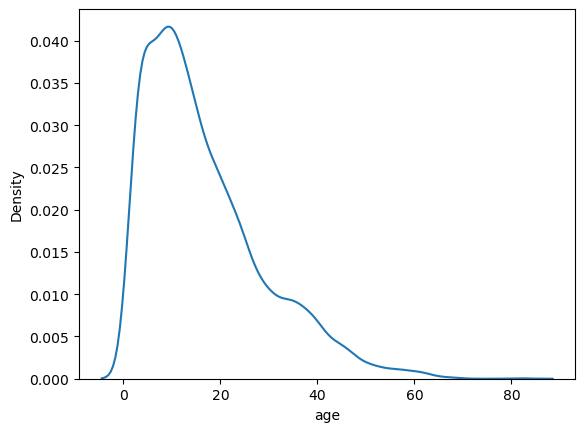

In [126]:
sns.kdeplot(temp_relfeat['age'])

<Axes: xlabel='age_log', ylabel='Density'>

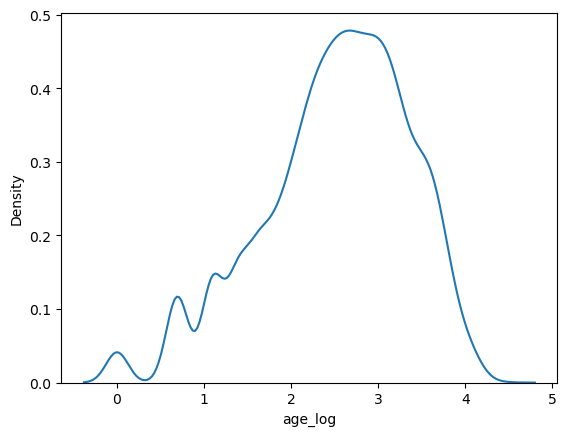

In [127]:
sns.kdeplot(temp_relfeat['age_log'])

<Axes: xlabel='age_normalized', ylabel='Density'>

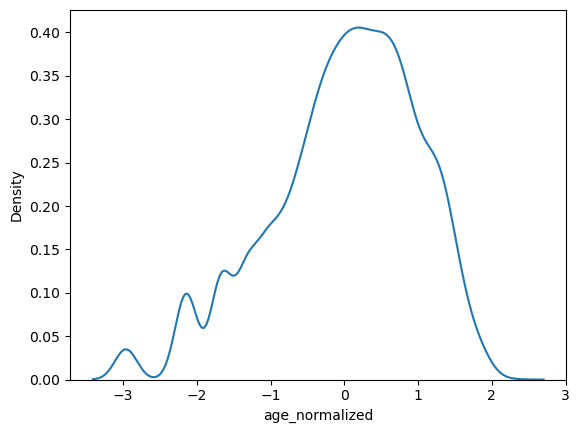

In [128]:
sns.kdeplot(temp_relfeat['age_normalized'])

In [129]:
#ready_df.insert(8, 'season_norm', temp_relfeat['year_normalized'])
ready_df.insert(8, 'age_norm', temp_relfeat['age_normalized'])
ready_df.insert(9, 'year_sin', temp_relfeat['year_sin'])
ready_df.insert(10, 'year_cos', temp_relfeat['year_cos'])

ready_df

,name,episodes,status,duration_per_ep,cours_Winter,cours_Spring,cours_Summer,cours_Autumn,age_norm,year_sin,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
0,Frieren: Beyond Journey's End,0.352777,0.0,-0.156525,0.0,0.0,0.0,1.0,-1.663814,-0.226497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Fullmetal Alchemist: Brotherhood,1.198986,0.0,-0.156525,0.0,1.0,0.0,0.0,0.382567,-0.967147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Steins;Gate,0.258754,0.0,-0.156525,0.0,1.0,0.0,0.0,0.234893,-0.999592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Attack on Titan Season 3 Part 2,-0.070327,0.0,-0.195777,0.0,1.0,0.0,0.0,-0.664288,-0.633012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Gintama Season 4,0.893411,0.0,-0.156525,0.0,1.0,0.0,0.0,-0.131039,-0.909632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,Ex-Arm,-0.023316,0.0,-0.195777,1.0,0.0,0.0,0.0,-1.061234,-0.441221,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13339,Clap Vocalism,-0.281879,0.0,-1.020079,1.0,0.0,0.0,0.0,1.946711,-0.791902,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,Abunai Sisters: Koko & Mika,-0.070327,0.0,-0.980826,1.0,0.0,0.0,0.0,0.382567,-0.967147,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13341,Mars of Destruction,-0.281879,0.0,-0.352787,0.0,0.0,1.0,0.0,0.631883,-0.755750,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [130]:
ready_df = ready_df.drop(columns='season')
ready_df

,name,episodes,status,duration_per_ep,cours_Winter,cours_Spring,cours_Summer,cours_Autumn,age_norm,year_sin,...,rating_Rx - Hentai,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
0,Frieren: Beyond Journey's End,0.352777,0.0,-0.156525,0.0,0.0,0.0,1.0,-1.663814,-0.226497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Fullmetal Alchemist: Brotherhood,1.198986,0.0,-0.156525,0.0,1.0,0.0,0.0,0.382567,-0.967147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Steins;Gate,0.258754,0.0,-0.156525,0.0,1.0,0.0,0.0,0.234893,-0.999592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Attack on Titan Season 3 Part 2,-0.070327,0.0,-0.195777,0.0,1.0,0.0,0.0,-0.664288,-0.633012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Gintama Season 4,0.893411,0.0,-0.156525,0.0,1.0,0.0,0.0,-0.131039,-0.909632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13338,Ex-Arm,-0.023316,0.0,-0.195777,1.0,0.0,0.0,0.0,-1.061234,-0.441221,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13339,Clap Vocalism,-0.281879,0.0,-1.020079,1.0,0.0,0.0,0.0,1.946711,-0.791902,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13340,Abunai Sisters: Koko & Mika,-0.070327,0.0,-0.980826,1.0,0.0,0.0,0.0,0.382567,-0.967147,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13341,Mars of Destruction,-0.281879,0.0,-0.352787,0.0,0.0,1.0,0.0,0.631883,-0.755750,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [131]:
ready_df.to_excel('anime_ready.xlsx')

<h2>Получение данных для написания функции рекомендаций</h2>

<h3>Этап 7: Построение общих векторов для каждого аниме</h3>

In [132]:
# Преобразуем DataFrame в numpy array
anime_vectors = ready_df.drop(columns=['name', 'image', 'trailer', 'synopsis']).values
print(f"Размерность матрицы: {anime_vectors.shape}")

# Тип данных для оптимизации памяти
anime_vectors = anime_vectors.astype(np.float32)
print(f"Тип данных: {anime_vectors.dtype}")

Размерность матрицы: (13343, 228)
Тип данных: float32


In [133]:
# Сохраняем названия аниме и сопоставляем их с индексами
anime_titles = ready_df['name'].values
feature_names = ready_df.drop(columns=['name', 'image', 'trailer', 'synopsis']).columns.tolist()

# Создаем словарь для удобства работы
anime_data = {
    'feature_matrix': anime_vectors,
    'titles': anime_titles,
    'feature_names': feature_names,
    'title_to_index': {title: idx for idx, title in enumerate(anime_titles)}
}

anime_data

{'feature_matrix': array([[ 0.3527773 ,  0.        , -0.156525  , ...,  0.        ,
          1.        ,  0.        ],
        [ 1.1989863 ,  0.        , -0.156525  , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.2587541 ,  0.        , -0.156525  , ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [-0.07032716,  0.        , -0.9808262 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.2818794 ,  0.        , -0.3527872 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.2818794 ,  0.        , -0.3527872 , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32),
 'titles': array(["Frieren: Beyond Journey's End",
        'Fullmetal Alchemist: Brotherhood', 'Steins;Gate', ...,
        'Abunai Sisters: Koko & Mika', 'Mars of Destruction',
        'Skelter Heaven'], dtype=object),
 'feature_names': ['episodes',
  'status',
  'duration_per_ep',
  'cours_Winter',
  'cours_Spring',
  'cours_Summer',
  '

<h2>Кластеризация</h2>

<h3>Этап 8: Снижение размерности</h3>

<h4>PCA</h4>

In [134]:
pca = PCA(n_components=2)
anime_data['pca_feature_matrix'] = pca.fit_transform(anime_data['feature_matrix'])
anime_data['pca_feature_matrix']

array([[-0.92662036,  5.272862  ],
       [-0.91946226,  8.680211  ],
       [-0.9226982 ,  6.284971  ],
       ...,
       [-0.9305899 , -3.2671356 ],
       [-0.9312281 , -3.6414418 ],
       [-0.9310663 , -3.9671338 ]], dtype=float32)

In [135]:
pca.explained_variance_ratio_

array([0.99180305, 0.00117429], dtype=float32)

Text(0.5, 1.0, 'Снижение размерности методом PCA')

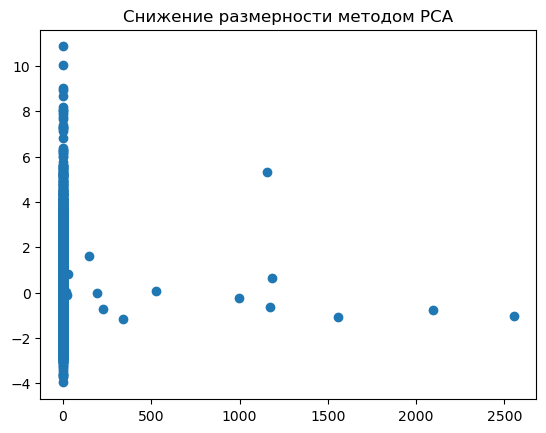

In [138]:
plt.scatter(x=anime_data['pca_feature_matrix'][:, 0], y=anime_data['pca_feature_matrix'][:, 1])
plt.title('Снижение размерности методом PCA')

<h4>UMAP</h4>

In [361]:
cutter = umap.UMAP(n_neighbors=24)
anime_data['umap_feature_matrix'] = cutter.fit_transform(anime_data['feature_matrix'])
anime_data['umap_feature_matrix']

array([[ 2.7867205 , -1.9875437 ],
       [ 4.145998  , -2.123598  ],
       [ 3.9632406 , -2.1006224 ],
       ...,
       [-0.20065406,  3.8930387 ],
       [-0.62171805,  3.8540356 ],
       [-0.6330917 ,  3.8259394 ]], dtype=float32)

[]

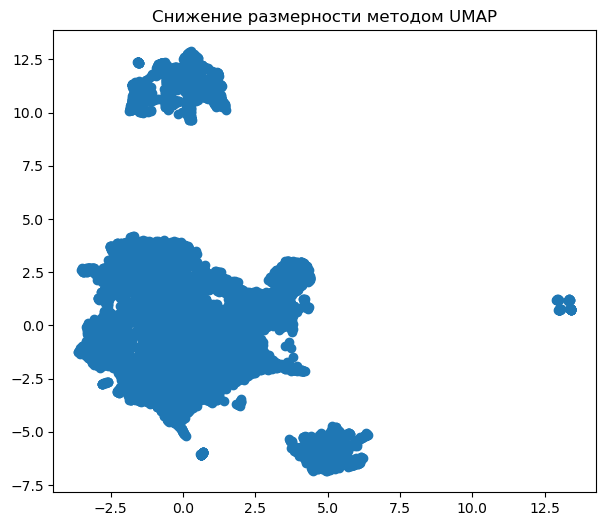

In [362]:
plt.figure(figsize=(7, 6))
plt.scatter(x=anime_data['umap_feature_matrix'][:, 0], y=anime_data['umap_feature_matrix'][:, 1])
plt.title('Снижение размерности методом UMAP')
plt.plot()

<h3>Этап 9: Построение кластеров</h3>

<h4>KMeans</h4>

In [147]:
#По исходным данным
best_m = 0
best_score_m = 0
for i in range(139, 152):
    kmeans_m = KMeans(n_clusters=i, algorithm='elkan', random_state=42)
    kmeans_m.fit(anime_data['feature_matrix'])
    score = round(silhouette_score(anime_data['feature_matrix'], labels=kmeans_m.labels_), 4)
    if score > best_score_m:
        best_score_m = score
        best_m = i
    print('Clusters: {} --- Silhouette_score: {}'.format(i, score))

print('Best clusters: {} --- Best silhouette_score: {}'.format(best_m, best_score_m))

Clusters: 139 --- Silhouette_score: 0.050700001418590546
Clusters: 140 --- Silhouette_score: 0.050200000405311584
Clusters: 141 --- Silhouette_score: 0.05050000175833702
Clusters: 142 --- Silhouette_score: 0.05040000006556511
Clusters: 143 --- Silhouette_score: 0.0502999983727932
Clusters: 144 --- Silhouette_score: 0.05130000039935112
Clusters: 145 --- Silhouette_score: 0.051500000059604645
Clusters: 146 --- Silhouette_score: 0.052000001072883606
Clusters: 147 --- Silhouette_score: 0.051899999380111694
Clusters: 148 --- Silhouette_score: 0.05180000141263008
Clusters: 149 --- Silhouette_score: 0.05719999969005585
Clusters: 150 --- Silhouette_score: 0.05700000002980232
Clusters: 151 --- Silhouette_score: 0.05620000138878822
Best clusters: 149 --- Best silhouette_score: 0.05719999969005585


In [148]:
#По методу PCA
best_pca = 0
best_score_pca = 0
for i in range(10, 19):
    clust_pca = KMeans(n_clusters=i, random_state=18)
    clust_pca.fit(anime_data['pca_feature_matrix'])
    score = silhouette_score(anime_data['pca_feature_matrix'], labels=clust_pca.labels_)
    if score > best_score_pca:
        best_pca = i
        best_score_pca = score
    print('Clusters: {} --- Silohouette score: {}'.format(i, score))

print('Best clusters: {} --- Best silohouette score: {}'.format(best_pca, best_score_pca))

Clusters: 10 --- Silohouette score: 0.5433909296989441
Clusters: 11 --- Silohouette score: 0.5247783064842224
Clusters: 12 --- Silohouette score: 0.5270131826400757
Clusters: 13 --- Silohouette score: 0.5269297361373901
Clusters: 14 --- Silohouette score: 0.5161713361740112
Clusters: 15 --- Silohouette score: 0.5015594959259033
Clusters: 16 --- Silohouette score: 0.5015129446983337
Clusters: 17 --- Silohouette score: 0.5155423879623413
Clusters: 18 --- Silohouette score: 0.5093940496444702
Best clusters: 10 --- Best silohouette score: 0.5433909296989441


In [149]:
kmeans_pca = KMeans(n_clusters=best_pca, random_state=18)
kmeans_pca.fit(anime_data['pca_feature_matrix'])
counter = {i: len(np.where(kmeans_pca.labels_ == i)[0]) for i in set(kmeans_pca.labels_)}
counter

{0: 7147, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 3, 7: 3, 8: 6184, 9: 1}

In [384]:
#По методу UMAP
best = 0
best_score = 0
for i in range(18, 28):
    clust = KMeans(n_clusters=i, random_state=18)
    clust.fit(anime_data['umap_feature_matrix'])
    score = silhouette_score(anime_data['umap_feature_matrix'], labels=clust.labels_)
    if score > best_score:
        best = i
        best_score = score
    print('Clusters: {} --- Silohouette score: {}'.format(i, score))

print('Best clusters: {} --- Best silohouette score: {}'.format(best, best_score))

Clusters: 18 --- Silohouette score: 0.4176047146320343
Clusters: 19 --- Silohouette score: 0.4217793345451355
Clusters: 20 --- Silohouette score: 0.4272027909755707
Clusters: 21 --- Silohouette score: 0.4520636200904846
Clusters: 22 --- Silohouette score: 0.459271103143692
Clusters: 23 --- Silohouette score: 0.4223102331161499
Clusters: 24 --- Silohouette score: 0.41181278228759766
Clusters: 25 --- Silohouette score: 0.41185659170150757
Clusters: 26 --- Silohouette score: 0.4096461236476898
Clusters: 27 --- Silohouette score: 0.4068096876144409
Best clusters: 22 --- Best silohouette score: 0.459271103143692


In [385]:
kmeans = KMeans(n_clusters=best, random_state=18)
kmeans.fit(anime_data['umap_feature_matrix'])
anime_data['KMeans_clusters'] = {anime_titles[i]: kmeans.labels_[i] for i in range(len(anime_titles))}

In [386]:
counter = {i: len(np.where(kmeans.labels_ == i)[0]) for i in set(kmeans.labels_)}
counter

{0: 600,
 1: 731,
 2: 422,
 3: 1163,
 4: 855,
 5: 83,
 6: 554,
 7: 396,
 8: 376,
 9: 589,
 10: 445,
 11: 885,
 12: 872,
 13: 406,
 14: 835,
 15: 410,
 16: 362,
 17: 648,
 18: 923,
 19: 666,
 20: 614,
 21: 508}

<h4>DBSCAN</h4>

In [381]:
clust = DBSCAN(eps=0.4, min_samples=60, metric='canberra')
clust.fit(anime_data['umap_feature_matrix'])
wybros = len(np.where(clust.labels_ == -1)[0])
score = silhouette_score(anime_data['umap_feature_matrix'], labels=clust.labels_)
print(wybros, score, set(clust.labels_))

485 0.3940702 {0, 1, 2, 3, 4, 5, 6, 7, -1}


In [383]:
anime_data['DBSCAN_clusters'] = {anime_titles[i]: clust.labels_[i] for i in range(len(anime_titles))}

In [382]:
counter = {i: len(np.where(clust.labels_ == i)[0]) for i in set(clust.labels_)}
counter

{0: 2701, 1: 1163, 2: 2578, 3: 2706, 4: 2302, 5: 682, 6: 643, 7: 83, -1: 485}

<h4>MiniBatchKMeans</h4>

In [387]:
best = 0
best_score = 0
for i in range(18, 28):
    mb_kmeans = MiniBatchKMeans(n_clusters=i, init='random', tol=0.000568, random_state=18)
    mb_kmeans.fit(anime_data['umap_feature_matrix'])
    score = silhouette_score(anime_data['umap_feature_matrix'], mb_kmeans.labels_)
    if score > best_score:
        best = i
        best_score = score
    print('N_clusters: {} --- Silhouette score: {}'.format(i, score))

print('Best n_clusters: {} --- Best silhouette score: {}'.format(best, best_score))


N_clusters: 18 --- Silhouette score: 0.404064804315567
N_clusters: 19 --- Silhouette score: 0.42661815881729126
N_clusters: 20 --- Silhouette score: 0.3698415458202362
N_clusters: 21 --- Silhouette score: 0.42521440982818604
N_clusters: 22 --- Silhouette score: 0.46321237087249756
N_clusters: 23 --- Silhouette score: 0.38181743025779724
N_clusters: 24 --- Silhouette score: 0.37729546427726746
N_clusters: 25 --- Silhouette score: 0.44513076543807983
N_clusters: 26 --- Silhouette score: 0.3588044047355652
N_clusters: 27 --- Silhouette score: 0.40801411867141724
Best n_clusters: 22 --- Best silhouette score: 0.46321237087249756


In [388]:
mb_kmeans = MiniBatchKMeans(n_clusters=best, init='random', tol=0.000568, random_state=18)
mb_kmeans.fit(anime_data['umap_feature_matrix'])
anime_data['miniBatchKMeans_clusters'] = {anime_titles[i]: mb_kmeans.labels_[i] for i in range(len(anime_titles))}

In [389]:
counter = {i: len(np.where(mb_kmeans.labels_ == i)[0]) for i in set(mb_kmeans.labels_)}
counter

{0: 582,
 1: 383,
 2: 394,
 3: 1019,
 4: 584,
 5: 525,
 6: 373,
 7: 639,
 8: 812,
 9: 281,
 10: 372,
 11: 1163,
 12: 944,
 13: 421,
 14: 460,
 15: 452,
 16: 611,
 17: 1340,
 18: 579,
 19: 491,
 20: 83,
 21: 835}

<h4>Spectral Clustering</h4>

In [393]:
best = 0
best_score = 0
for i in range(18, 28):
    scl = SpectralClustering(n_clusters=i, random_state=42)
    scl.fit(anime_data['umap_feature_matrix'])
    score = silhouette_score(anime_data['umap_feature_matrix'], scl.labels_)
    if score > best_score:
        best = i
        best_score = score
    print('N_clusters: {} --- Silhouette score: {}'.format(i, score))

print('Best n_clusters: {} --- Best silhouette score: {}'.format(best, best_score))

N_clusters: 18 --- Silhouette score: 0.43213754892349243
N_clusters: 19 --- Silhouette score: 0.4337542653083801
N_clusters: 20 --- Silhouette score: 0.4351263642311096
N_clusters: 21 --- Silhouette score: 0.4415612518787384
N_clusters: 22 --- Silhouette score: 0.4390674829483032
N_clusters: 23 --- Silhouette score: 0.43552955985069275
N_clusters: 24 --- Silhouette score: 0.3597584366798401
N_clusters: 25 --- Silhouette score: 0.34758123755455017
N_clusters: 26 --- Silhouette score: 0.36421462893486023
N_clusters: 27 --- Silhouette score: 0.38858547806739807
Best n_clusters: 21 --- Best silhouette score: 0.4415612518787384


In [395]:
scl = SpectralClustering(n_clusters=best, random_state=42)
scl.fit(anime_data['umap_feature_matrix'])
anime_data['spectralClustering_clusters'] = {anime_titles[i]: scl.labels_[i] for i in range(len(anime_titles))}

In [396]:
counter = {i: len(np.where(scl.labels_ == i)[0]) for i in set(scl.labels_)}
counter

{0: 830,
 1: 33,
 2: 1485,
 3: 83,
 4: 238,
 5: 355,
 6: 347,
 7: 491,
 8: 227,
 9: 1163,
 10: 932,
 11: 263,
 12: 834,
 13: 692,
 14: 1080,
 15: 340,
 16: 1627,
 17: 334,
 18: 869,
 19: 542,
 20: 578}

<h4>Birch</h4>

In [390]:
best = 0
best_score = 0
for i in range(18, 28):
    clust = Birch(n_clusters=i)
    clust.fit(anime_data['umap_feature_matrix'])
    score = silhouette_score(anime_data['umap_feature_matrix'], labels=clust.labels_)
    if score > best_score:
        best = i
        best_score = score
    print('Clusters: {} --- Silohouette score: {}'.format(i, score))

print('Best clusters: {} --- Best silohouette score: {}'.format(best, best_score))

Clusters: 18 --- Silohouette score: 0.4281550347805023
Clusters: 19 --- Silohouette score: 0.430326372385025
Clusters: 20 --- Silohouette score: 0.4267895817756653
Clusters: 21 --- Silohouette score: 0.4229118227958679
Clusters: 22 --- Silohouette score: 0.4129904508590698
Clusters: 23 --- Silohouette score: 0.3779520094394684
Clusters: 24 --- Silohouette score: 0.37756261229515076
Clusters: 25 --- Silohouette score: 0.38808876276016235
Clusters: 26 --- Silohouette score: 0.39187681674957275
Clusters: 27 --- Silohouette score: 0.3893621265888214
Best clusters: 19 --- Best silohouette score: 0.430326372385025


In [391]:
bch = Birch(n_clusters=best)
bch.fit(anime_data['umap_feature_matrix'])
anime_data['Birch_clusters'] = {anime_titles[i]: bch.labels_[i] for i in range(len(anime_titles))}

In [392]:
counter = {i: len(np.where(bch.labels_ == i)[0]) for i in set(bch.labels_)}
counter

{0: 843,
 1: 981,
 2: 360,
 3: 856,
 4: 1163,
 5: 326,
 6: 699,
 7: 560,
 8: 1159,
 9: 1092,
 10: 910,
 11: 83,
 12: 579,
 13: 994,
 14: 398,
 15: 243,
 16: 796,
 17: 789,
 18: 512}

<h2>Определение и проверка функции</h2>

<h3>Этап 10: Написание функции для подсчёта косинусных сходств</h3>

<h4>Функции</h4>

<strong>Получение индекса</strong>

In [397]:
def get_index(title):
    global anime_data
    if title in anime_data['titles']:
        return anime_data['title_to_index'][title]
    else:
        print('This anime was not found')

<strong>Получение кластера</strong>

In [398]:
def get_cluster(title, method):
    global anime_data
    if method == 'KMeans':
        cluster_id = anime_data['KMeans_clusters'][title]
        sames = [title for title in anime_data['KMeans_clusters'] if anime_data['KMeans_clusters'][title] == cluster_id]
    elif method == 'MiniBatchKMeans':
        cluster_id = anime_data['miniBatchKMeans_clusters'][title]
        sames = [title for title in anime_data['miniBatchKMeans_clusters'] if anime_data['miniBatchKMeans_clusters'][title] == cluster_id]
    elif method == 'DBSCAN':
        cluster_id = anime_data['DBSCAN_clusters'][title]
        sames = [title for title in anime_data['DBSCAN_clusters'] if anime_data['DBSCAN_clusters'][title] == cluster_id]
    elif method == 'SpectralClustering':
        cluster_id = anime_data['spectralClustering_clusters'][title]
        sames = [title for title in anime_data['spectralClustering_clusters'] if anime_data['spectralClustering_clusters'][title] == cluster_id]
    elif method == 'Birch':
        cluster_id = anime_data['Birch_clusters'][title]
        sames = [title for title in anime_data['Birch_clusters'] if anime_data['Birch_clusters'][title] == cluster_id]
    else:
        print('Method {} is unavailable'.format(method))
        
    return sames

<strong>Отбор по фильтрам</strong>

In [399]:
# По ТВ-сезону
def cour_criterion(cours):
    global anime_data
    index_list = []
    anime_check = []
    control_sum = 0
    
    for i in cours:
        if 'cours_{}'.format(i) not in anime_data['feature_names']:
            print('Cour: {} not found in cours'.format(i))
            control_sum += 1
    if control_sum == 0:
        for i in cours:
            index_list.append(anime_data['feature_names'].index('cours_{}'.format(i)))
        for i in range(len(anime_data['titles'])):
            crit_sum = anime_data["feature_matrix"][i][index_list].sum()
            if crit_sum > 0.99:
                anime_check.append(anime_data['titles'][i])
        return index_list, anime_check
    else:
        print('Error in cour selection')

# По жанру
def genre_criterion(genres):
    global anime_data
    index_list = []
    anime_check = []
    control_sum = 0
    
    for i in genres:
        if 'genre_{}'.format(i) not in anime_data['feature_names']:
            print('Genre: {} not found in genres'.format(i))
            control_sum += 1
            
    if control_sum == 0:
        for i in genres:
            index_list.append(anime_data['feature_names'].index('genre_{}'.format(i)))
        for i in range(len(anime_data['titles'])):
            crit_sum = anime_data["feature_matrix"][i][index_list].sum()
            if crit_sum > 0.99:
                anime_check.append(anime_data['titles'][i])
        return index_list, anime_check
    else:
        print('Error in genre selection')

# По возрастному рейтингу
def rating_criterion(ratings):
    global anime_data
    index_list = []
    anime_check = []
    control_sum = 0
    
    for i in ratings:
        if 'rating_{}'.format(i) not in anime_data['feature_names']:
            print('Rating: {} not found in ratings'.format(i))
            control_sum += 1

    if control_sum == 0:
        for i in ratings:
            index_list.append(anime_data['feature_names'].index('rating_{}'.format(i)))
        for i in range(len(anime_data['titles'])):
            crit_sum = anime_data["feature_matrix"][i][index_list].sum()
            if crit_sum > 0.99:
                anime_check.append(anime_data['titles'][i])
        return index_list, anime_check
    else:
        print('Error in rating seelction')

# По студии
def studio_criterion(studios):
    global anime_data
    index_list = []
    anime_check = []
    control_sum = 0
    
    for i in studios:
        if 'studio_{}'.format(i) not in anime_data['feature_names']:
            print('Studio: {} not found in studios'.format(i))
            control_sum += 1
    if control_sum == 0:
        for i in studios:
            index_list.append(anime_data['feature_names'].index('studio_{}'.format(i)))
        for i in range(len(anime_data['titles'])):
            crit_sum = anime_data["feature_matrix"][i][index_list].sum()
            if crit_sum > 0.99:
                anime_check.append(anime_data['titles'][i])
        return index_list, anime_check
    else:
        print('Error in studio selection')

# По типу произведения
def type_criterion(types):
    global anime_data
    index_list = []
    anime_check = []
    control_sum = 0
    
    for i in types:
        if 'type_{}'.format(i) not in anime_data['feature_names']:
            print('Type: {} not found in types'.format(i))
            control_sum += 1

    if control_sum == 0:
        for i in types:
            index_list.append(anime_data['feature_names'].index('type_{}'.format(i)))
        for i in range(len(anime_data['titles'])):
            crit_sum = anime_data["feature_matrix"][i][index_list].sum()
            if crit_sum > 0.99:
                anime_check.append(anime_data['titles'][i])
        return index_list, anime_check
    else:
        print('Error in type selection')

<strong>Основная функция</strong>

In [402]:
def anime_rec(title, limit=10, cluster_method=None, cours=None, genres=None, ratings=None, studios=None, types=None):
    global anime_data
    index = get_index(title)
    
    # Отбор кластеров
    if cluster_method != None:
        cluster_same = get_cluster(title, cluster_method)
    else:
        cluster_same = anime_data['titles']
    
    # Выбор по телевизионному сезону
    if cours == None:
        cours_sort = anime_data['titles']
    else:
        cours_sort = cour_criterion(cours)[1]

    # Выбор по жанру
    if genres == None:
        genres_sort = anime_data['titles']
    else:
        genres_sort = genre_criterion(genres)[1]

    # Выбор по рейтингу
    if ratings == None:
        ratings_sort = anime_data['titles']
    else:
        ratings_sort = rating_criterion(ratings)[1]

    # Выбор по студиям
    if studios == None:
        studios_sort = anime_data['titles']
    else:
        studios_sort = studio_criterion(studios)[1]

    # Выбор по типу
    if types == None:
        types_sort = anime_data['titles']
    else:
        types_sort = type_criterion(types)[1]
        
    # Итоговый список тайтлов
    relevant = list(set(cluster_same) & set(cours_sort) & set(genres_sort) & set(ratings_sort) & set(studios_sort) & set(types_sort))
    if title in relevant: relevant.remove(title)
    choice = [anime for anime in anime_data['titles'] if anime in relevant]
    # Проверка на присутствие данного тайтла в списке
    if type(index) == int:
        
        similarity_list = cosine_similarity([anime_data['feature_matrix'][index]], anime_data['feature_matrix'])[0]
        similarity_vector = dict(zip(anime_data['titles'], similarity_list))
        selected = {key: similarity_vector[key] for key in choice}
        sorted_sv = sorted(selected.items(), key=lambda item: item[1], reverse=True)
        
        return sorted_sv[:min([limit, len(relevant)])]
    else:
        print('error_base')

In [414]:
anime_rec('Clannad: After Story')

[('Clannad', 0.9536038),
 ('Love, Chunibyo & Other Delusions!', 0.9239121),
 ('K-ON!', 0.89206),
 ('Violet Evergarden', 0.8806499),
 ('My Teen Romantic Comedy SNAFU', 0.8669323),
 ('Beyond the Boundary', 0.86140776),
 ('Your Lie in April', 0.86047935),
 ('Maid Sama!', 0.8527058),
 ('Golden Time', 0.8496964),
 ('My Teen Romantic Comedy SNAFU TOO!', 0.84667134)]

In [403]:
anime_rec('Clannad', limit=15, cours=['Summer'], genres=['action', 'romance'], ratings=['PG-13 - Teens 13 or older', 'Rx - Hentai'], studios=['a-1 pictures', 'kyoto animation', 'toei animation'], types=['OVA', 'Special', 'TV', 'Movie'])

[('Sword Art Online', 0.8488445),
 ('Sword Art Online II', 0.8343228),
 ('Clannad: Another World, Tomoyo Chapter', 0.6650773),
 ('Dragon Ball Super', 0.6512465),
 ('The Seven Deadly Sins: Signs of Holy War', 0.6385747),
 ('Clannad: After Story - Another World, Kyou Chapter', 0.62135166),
 ('Full Metal Panic? Fumoffu', 0.49098036),
 ('Lycoris Recoil', 0.48159423),
 ('Wagnaria!!3', 0.44757164),
 ('Uta no Prince Sama', 0.4117088),
 ('Love, Chunibyo & Other Delusions!: Heart Throb - The Rikka Wars',
  0.36741588),
 ('Air in Summer', 0.35515898),
 ('Beyond the Boundary: Daybreak', 0.32885492),
 ('The Anthem of the Heart', 0.31870893),
 ('Makeine: Too Many Losing Heroines!', 0.31333295)]

<h2>Описание возможностей функции выдачи рекомендаций</h2>

<h3>Этап 11: Прописывание руководства пользователя</h3>

<h4>Общие возможности функции выдачи рекомендаций аниме</h4>

<br>Функция anime_rec предполагает выдачу рекомендаций по одному заданному тайтлу на основе косинусного сходства
<br><i><br>Для каждого тайтла было определено 228 параметров, по которым рассчитывается косниусное сходство</i>
<br><u><br>Среди параметров:</u>
<br><i><br>1. Средняя оценка
<br>2. Количество оценок
<br>3. Количество эпизодов
<br>4. Длительность одного эпизода
<br>5. Год выпуска
<br>6. Циклические параметры, рассчитанные на основе года
<br>7. Время, прошедшее с момента выхода тайтла
<br>8. Телевизионный сезон, в котором вышла первая серия аниме
<br>9. Текущий статус тайтла (показ завершён или нет)
<br>10. Жанр
<br>11. Студия
<br>12. Возрастной рейтинг
<br>13. Тип</i>

<strong>Замечание</strong>
<br><br>Функция принимает в качестве аргумента название тайтла
<br><br>Поскольку база данных аниме заимствована с сайта myanimelist.net, необходимо удостовериться, что название тайтла введено в <strong>точном соответствии</strong> с таковым на сайте
<br><br>Для сверки названия также можно использовать сайт shikimori.one, так как он содержит названия, аналогичные международным (при этом необходимо использовать англоязычную часть названия тайтла

<h4>Функции фильтрации</h4>

<u>Для лучшего учёта предпочтений пользователя имеется возможность фильтрации тайтлов по различным категориям</u>

<strong>Ограничение количества выдаваемых тайтлов</strong>
<br><br><u>Для ручного ограничения количества рекомендуемых тайтлов необходимо задать соответсвтующее число в параметре <strong>limit</strong></u>
<br><br><i>Значение по умолчанию: 10</i>

<strong>Выбор метода кластеризации</strong>
<br><br><u>Для выбора используемого метода кластеризации необходимо задать параметр <strong>cluster_method</strong></u>
<br><br>Допустимые значения:
<br><table>
<tr><th>№</th><th>Название</th></tr>
<tr><td>1</td><td>Birch</td></tr>
<tr><td>2</td><td>DBSCAN</td></tr>
<tr><td>3</td><td>KMeans</td></tr>
<tr><td>4</td><td>MiniBatchKMeans</td></tr>
<tr><td>5</td><td>SpectralClustering</td></tr></table>
<br><br><i>По умолчанию кластеризация не производится</i>

<strong>Фильтрация по ТВ-сезону</strong>
<br><br><u>Для использования данного фильтра необходимо в вызове функции объявить параметр <strong>cours</strong></u>
<br><br>Допустимые значения:
<table>
<tr><th>№</th><th>Название</th><th>Фильтр</th></tr>
 <tr><td>1</td><td>Winter</td><td>Зима: январь-март</td></tr>
 <tr><td>2</td><td>Spring</td><td>Весна: апрель-июнь</td></tr>
 <tr><td>3</td><td>Summer</td><td>Лето: июль-сентябрь</td></tr>
 <tr><td>4</td><td>Autumn</td><td>Осень: октябрь-декабрь</td></tr>
 </table>
<br><br><i>По умолчанию фильтрация не осуществляется</i>

<strong>Фильтрация по жанру</strong>
<br><br><u>Для использования данного фильтра необходимо в вызове функции объявить параметр <strong>genres</strong></u>
<br><br>Допустимые значения:
<table>
<tr><th>№</th><th>Название</th><th>Фильтр</th></tr>
<tr><td>1</td><td>action</td><td>Экшен</td></tr>
<tr><td>2</td><td>adventure</td><td>Приключения</td></tr>
<tr><td>3</td><td>avant garde</td><td>Авангард</td></tr>
<tr><td>4</td><td>award winning</td><td>Удостоено наград</td></tr>
<tr><td>5</td><td>boys love</td><td>Сёнен-ай</td></tr>
<tr><td>6</td><td>comedy</td><td>Комедия</td></tr>
<tr><td>7</td><td>drama</td><td>Драма</td></tr>
<tr><td>8</td><td>ecchi</td><td>Этти</td></tr>
<tr><td>9</td><td>erotica</td><td>Эротика</td></tr>
<tr><td>10</td><td>fantasy</td><td>Фентэзи</td></tr>
<tr><td>11</td><td>girls love</td><td>Сёдзё-ай</td></tr>
<tr><td>12</td><td>gourmet</td><td>Гурман</td></tr>
<tr><td>13</td><td>hentai</td><td>Хентай</td></tr>
<tr><td>14</td><td>horror</td><td>Хорро</td></tr>
<tr><td>15</td><td>mystery</td><td>Мистика</td></tr>
<tr><td>16</td><td>romance</td><td>Романтика</td></tr>
<tr><td>17</td><td>sci-fi</td><td>Научная фантастика</td></tr>
<tr><td>18</td><td>slice of life</td><td>Повседневность</td></tr>
<tr><td>19</td><td>sports</td><td>Спортивное</td></tr>
<tr><td>20</td><td>supernatural</td><td>Сверхъестественное</td></tr>
<tr><td>21</td><td>suspense</td><td>Триллер</td></tr>
</table>

<br><br><i>По умолчанию фильтрация не осуществляется</i>

<strong>Фильтрация по возрастному рейтингу</strong>
<br><br><u>Для использования данного фильтра необходимо в вызове функции объявить параметр <strong>ratings</strong></u>
<br><br>Допустимые значения:
<table>
<tr><th>№</th><th>Название</th></tr>
<tr><td>1</td><td>nan</td></tr>
<tr><td>2</td><td>G - All Ages</td></tr>
<tr><td>3</td><td>PG - Children</td></tr>
<tr><td>4</td><td>PG-13 - Teens 13 or older</td></tr>
<tr><td>5</td><td>R - 17+ (violence & profanity)</td></tr>
<tr><td>6</td><td>R+ - Mild Nudity</td></tr>
<tr><td>7</td><td>Rx - Hentai</td></tr>
</table>
<br><br><i>По умолчанию фильтрация не осуществляется</i>

<strong>Фильтрация по студии</strong>
<br><br><u>Для использования данного фильтра необходимо в вызове функции объявить параметр <strong>studios</strong></u>
<br><br>Допустимые значения:
<table>  
    <thead>    
        <tr><th>№</th> <th>Название</th> <th>№</th> <th>Название</th> <th>№</th> <th>Название</th> <th>№</th> <th>Название</th></tr>
    </thead>  
    <tbody>    
        <tr> <td>1</td><td>8bit</td><td>46</td><td>fonishia</td>
            <td>91</td><td>memory-tech</td><td>136</td><td>studio deen</td>
        </tr>
        <tr> <td>2</td><td>a-1 pictures</td><td>47</td><td>frontier works</td>
            <td>92</td><td>milky animation label</td><td>137</td><td>studio gokumi</td>
        </tr>
        <tr> <td>3</td><td>abc animation</td><td>48</td><td>fuji tv</td>
            <td>93</td><td>movic</td><td>138</td><td>studio hibari</td>
        </tr>
        <tr> <td>4</td><td>aic</td><td>49</td><td>gainax</td>
            <td>94</td><td>nbcuniversal entertainment japan</td><td>139</td><td>studio mausu</td>
        </tr>
        <tr> <td>5</td><td>aqua aris</td><td>50</td><td>gallop</td>
            <td>95</td><td>nhk</td><td>140</td><td>studio puyukai</td>
        </tr>
        <tr><td>6</td><td>ascii media works</td><td>51</td>
            <td>genco</td><td>96</td><td>nhk enterprises</td><td>141</td><td>sunrise</td>
        </tr>
        <tr> <td>7</td><td>at-x</td><td>52</td><td>geneon entertainment</td>
            <td>97</td><td>nagoya broadcasting network</td><td>142</td><td>t-rex</td>
        </tr>
        <tr> <td>8</td><td>actas</td><td>53</td><td>glovision</td>
            <td>98</td><td>nihon ad systems</td><td>143</td><td>tbs</td>
        </tr>
        <tr> <td>9</td><td>ajia-do</td><td>54</td>
            <td>gonzo</td><td>99</td><td>nippon animation</td><td>144</td><td>tms entertainment</td>
        </tr>
        <tr><td>10</td><td>anime antenna iinkai</td><td>55</td><td>good smile company</td>
            <td>100</td><td>nippon columbia</td><td>145</td><td>tnk</td>
        </tr> 
        <tr> <td>11</td><td>aniplex</td><td>56</td><td>group tac</td>
            <td>101</td><td>nippon television network</td><td>146</td><td>toho</td>
        </tr>
        <tr> <td>12</td><td>arms</td><td>57</td><td>hakuhodo dy media partners</td>
            <td>102</td><td>olm</td><td>147</td><td>toho animation</td>
        </tr>
        <tr><td>13</td><td>artland</td><td>58</td><td>hakuhodo dy music &amp; pictures</td>
            <td>103</td><td>omnibus promotion</td><td>148</td><td>tv asahi</td>
        </tr>
        <tr><td>14</td><td>asahi broadcasting</td><td>59</td><td>hakusensha</td>
            <td>104</td><td>p.a. works</td><td>149</td><td>tv tokyo</td>
        </tr>
        <tr><td>15</td><td>asatsu dk</td><td>60</td><td>half h.p studio</td>
            <td>105</td><td>pierrot</td><td>150</td><td>tv tokyo music</td>
        </tr>
        <tr><td>16</td><td>ashi productions</td><td>61</td><td>haoliners animation league</td>
            <td>106</td><td>pink pineapple</td><td>151</td><td>tatsunoko production</td>
        </tr>
        <tr><td>17</td><td>asmik ace</td><td>62</td><td>houbunsha</td>
            <td>107</td><td>pioneer ldc</td><td>152</td><td>tencent animation &amp; comics</td>
        </tr>
        <tr><td>18</td><td>avex entertainment</td><td>63</td><td>imagine</td> 
            <td>108</td><td>poro</td><td>153</td><td>tencent video</td>
        </tr>
        <tr><td>19</td><td>avex pictures</td><td>64</td><td>j.c.staff</td>
            <td>109</td><td>pony canyon</td><td>154</td><td>tezuka productions</td>
        </tr>
        <tr><td>20</td><td>bs fuji</td><td>65</td><td>kss</td>
                <td>110</td><td>production i.g</td><td>155</td><td>toei animation</td>
        </tr>
        <tr><td>21</td><td>bs ntv</td><td>66</td><td>kadokawa</td>
            <td>111</td><td>queen bee</td><td>156</td><td>toei video</td>
        </tr>
            <tr><td>22</td><td>bs11</td><td>67</td><td>kadokawa media house</td>
            <td>112</td><td>rakuonsha</td><td>157</td><td>tohokushinsha film corporation</td>
        </tr>
        <tr>      <td>23</td><td>bandai</td><td>68</td><td>kadokawa shoten</td>
            <td>113</td><td>ruo hong culture</td><td>158</td><td>tokyo mx</td>
        </tr>
        <tr><td>24</td><td>bandai namco arts</td><td>69</td><td>kansai telecasting</td>
            <td>114</td><td>silver link.</td><td>159</td><td>tokyo movie shinsha</td>
        </tr>
        <tr><td>25</td><td>bandai namco entertainment</td><td>70</td><td>kinema citrus</td>
            <td>115</td><td>sammy</td><td>160</td><td>ultra super pictures</td>
        </tr>
        <tr><td>26</td><td>bandai namco filmworks</td><td>71</td><td>king records</td>
            <td>116</td><td>satelight</td><td>161</td><td>vap</td>
        </tr>
        <tr><td>27</td><td>bandai namco music live</td><td>72</td><td>klockworx</td>
            <td>117</td><td>sega</td><td>162</td><td>victor entertainment</td>
        </tr>
        <tr><td>28</td><td>bandai namco pictures</td><td>73</td><td>kodansha</td>
            <td>118</td><td>seven</td><td>163</td><td>wowow</td>
        </tr>
        <tr><td>29</td><td>bandai visual</td><td>74</td><td>kyoto animation</td>
            <td>119</td><td>shaft</td><td>164</td><td>warner bros. japan</td>
        </tr>
        <tr><td>30</td><td>bit grooove promotion</td><td>75</td><td>lidenfilms</td>
            <td>120</td><td>shin-ei animation</td><td>165</td><td>white fox</td>
        </tr>
        <tr><td>31</td><td>bones</td><td>76</td><td>lantis</td>
            <td>121</td><td>shochiku</td><td>166</td><td>wit studio</td> 
        </tr>
        <tr><td>32</td><td>brain\'s base</td><td>77</td><td>lerche</td>
            <td>122</td><td>shogakukan</td><td>167</td><td>xebec</td>
        </tr>
        <tr><td>33</td><td>bushiroad</td><td>78</td><td>lune-pictures</td>
            <td>123</td><td>shogakukan productions</td><td>168</td><td>y.o.u.c</td>
        </tr>
        <tr><td>34</td><td>cloverworks</td><td>79</td><td>mages.</td>
            <td>124</td><td>shogakukan-shueisha productions</td><td>169</td><td>yomiko advertising</td>
        </tr>
        <tr><td>35</td><td>comix wave films</td><td>80</td><td>mappa</td>
            <td>125</td><td>showgate</td><td>170</td><td>yomiuri tv enterprise</td>
        </tr>
        <tr><td>36</td><td>crunchyroll</td><td>81</td><td>ms pictures</td>
            <td>126</td><td>shueisha</td><td>171</td><td>yomiuri telecasting</td>
        </tr>
        <tr><td>37</td><td>dax production</td><td>82</td><td>madhouse</td>
            <td>127</td><td>sony music communications</td><td>172</td><td>youku</td>
        </tr>
        <tr><td>38</td><td>dle</td><td>83</td><td>magic bus</td>
            <td>128</td><td>sony music entertainment</td><td>173</td><td>zexcs</td>
        </tr>
        <tr><td>39</td><td>dmm pictures</td><td>84</td><td>magic capsule</td>
            <td>129</td><td>sotsu</td><td>174</td><td>animate film</td>
        </tr>
        <tr><td>40</td><td>dentsu</td><td>85</td><td>mainichi broadcasting system</td>
            <td>130</td><td>square enix</td><td>175</td><td>bilibili</td>
        </tr>
        <tr><td>41</td><td>digital works</td><td>86</td><td>marvelous entertainment</td>
            <td>131</td><td>starchild records</td><td>176</td><td>feel.</td>
        </tr>
        <tr><td>42</td><td>diomedéa</td><td>87</td><td>mary jane</td>
            <td>132</td><td>studio 1st</td><td>177</td><td>flying dog</td>
        </tr>
        <tr><td>43</td><td>docomo anime store</td><td>88</td><td>media factory</td>
            <td>133</td><td>studio 4°c</td><td>178</td><td>iqiyi</td>
        </tr>
        <tr><td>44</td><td>doga kobo</td><td>89</td><td>medianet</td>
            <td>134</td><td>studio 9 maiami</td><td>179</td><td>ufotable</td>
        </tr>
        <tr><td>45</td><td>dynamic planning</td><td>90</td><td>mediabank</td>
            <td>135</td><td>studio comet</td><td>180</td><td>other</td>
        </tr>
    </tbody>
</table>
<br><br><i>По умолчанию фильтрация не осуществляется</i>

<strong>Фильтрация по типу произведения</strong>
<br><br><u>Для использования данного фильтра необходимо в вызове функции объявить параметр <strong>types</strong></u>
<br><br>Допустимые значения:
<table>
<tr><th>№</th><th>Название</th><th>Фильтр</th></tr>
<tr><td>1</td><td>CM</td><td>Реклама</td></tr>
<tr><td>2</td><td>Movie</td><td>Фильм</td></tr>
<tr><td>3</td><td>Music</td><td>Музыкальный клип</td></tr>
<tr><td>4</td><td>ONA</td><td>Оригинальная сетевая анимация</td></tr>
<tr><td>5</td><td>OVA</td><td>Оригинальная видео-анмация</td></tr>
<tr><td>6</td><td>PV</td><td>Проморолик</td></tr>
<tr><td>7</td><td>Special</td><td>Спэшл</td></tr>
<tr><td>8</td><td>TV</td><td>Сериал</td></tr>
<tr><td>9</td><td>TV Special</td><td>ТВ-спэшл</td></tr>
</table>
<br><br><i>По умолчанию фильтрация не осуществляется</i>

<h2>Проверка работоспособности функции</h2>

In [188]:
anime_rec('Clannad')

[('Clannad: After Story', 0.9535471),
 ('Love, Chunibyo & Other Delusions!', 0.93377084),
 ('K-ON!', 0.90218884),
 ('Your Lie in April', 0.8997099),
 ('My Teen Romantic Comedy SNAFU', 0.8989556),
 ('Toradora!', 0.88924074),
 ('Steins;Gate', 0.8871202),
 ('Violet Evergarden', 0.8842967),
 ('My Teen Romantic Comedy SNAFU TOO!', 0.88373405),
 ('Angel Beats!', 0.8834305)]

In [439]:
anime_rec('Lucky☆Star', limit=14)

[('Nichijou - My Ordinary Life', 0.95542973),
 ('The Melancholy of Haruhi Suzumiya Season 2', 0.92738616),
 ('The Melancholy of Haruhi Suzumiya', 0.8918348),
 ('Hyouka', 0.84365565),
 ('K-ON!', 0.81710464),
 ('K-ON! Season 2', 0.81247807),
 ('Full Metal Panic? Fumoffu', 0.7805287),
 ('Love, Chunibyo & Other Delusions!', 0.76105034),
 ('Sound! Euphonium', 0.7398855),
 ('Clannad: After Story', 0.7394025),
 ('Ouran High School Host Club', 0.7321045),
 ('Love, Chunibyo & Other Delusions!: Heart Throb', 0.730735),
 ('Free! - Iwatobi Swim Club', 0.72748715),
 ('The World God Only Knows II', 0.7219454)]

In [437]:
anime_rec('Lucky☆Star', limit=14, studios=['kyoto animation'])

[('Nichijou - My Ordinary Life', 0.95542973),
 ('The Melancholy of Haruhi Suzumiya Season 2', 0.92738616),
 ('The Melancholy of Haruhi Suzumiya', 0.8918348),
 ('Hyouka', 0.84365565),
 ('K-ON!', 0.81710464),
 ('K-ON! Season 2', 0.81247807),
 ('Full Metal Panic? Fumoffu', 0.7805287),
 ('Love, Chunibyo & Other Delusions!', 0.76105034),
 ('Sound! Euphonium', 0.7398855),
 ('Clannad: After Story', 0.7394025),
 ('Love, Chunibyo & Other Delusions!: Heart Throb', 0.730735),
 ('Free! - Iwatobi Swim Club', 0.72748715),
 ('Free! Eternal Summer', 0.6924741),
 ('Clannad', 0.6834066)]

In [447]:
anime_rec('Lucky☆Star', limit=14, cluster_method='SpectralClustering')

[('Nichijou - My Ordinary Life', 0.95542973),
 ('The Melancholy of Haruhi Suzumiya Season 2', 0.92738616),
 ('The Melancholy of Haruhi Suzumiya', 0.8918348),
 ('K-ON! Season 2', 0.81247807),
 ('Full Metal Panic? Fumoffu', 0.7805287),
 ('Sound! Euphonium', 0.7398855),
 ('Free! - Iwatobi Swim Club', 0.72748715),
 ('The World God Only Knows II', 0.7219454),
 ('Lovely Complex', 0.7111772),
 ('Wagnaria!!', 0.7069386),
 ('Azumanga Daioh: The Animation', 0.703895),
 ('Daily Lives of High School Boys', 0.7019778),
 ('Baka & Test: Summon the Beasts', 0.7009197),
 ("Heaven's Lost Property", 0.6974757)]

In [190]:
anime_rec('The Melancholy of Haruhi Suzumiya', limit=14)

[('The Melancholy of Haruhi Suzumiya Season 2', 0.9181291),
 ('Lucky☆Star', 0.8913245),
 ('Hyouka', 0.870015),
 ('Nichijou - My Ordinary Life', 0.86507106),
 ('K-ON!', 0.80459607),
 ('K-ON! Season 2', 0.7938748),
 ('Love, Chunibyo & Other Delusions!', 0.7856802),
 ('Violet Evergarden', 0.76028),
 ('Love, Chunibyo & Other Delusions!: Heart Throb', 0.7598252),
 ('The Devil is a Part-Timer!', 0.75807357),
 ('Gurren Lagann', 0.7569295),
 ('My Teen Romantic Comedy SNAFU', 0.75392944),
 ('Steins;Gate', 0.75265735),
 ('Cowboy Bebop', 0.7489815)]

In [412]:
anime_rec("Komi Can't Communicate", types=['TV', 'OVA'])

[("Komi Can't Communicate Season 2", 0.89335537),
 ('Spy x Family Part 2', 0.8362475),
 ('Spy x Family', 0.81135195),
 ("Frieren: Beyond Journey's End", 0.78835267),
 ('Wotakoi: Love is Hard for Otaku', 0.7845931),
 ('Bocchi the Rock!', 0.78087974),
 ('Kill la Kill', 0.77763104),
 ('That Time I Got Reincarnated as a Slime Season 2', 0.77258456),
 ('My Hero Academia Season 4', 0.77185917),
 ('Haikyu!! 3rd Season', 0.7712791)]

In [192]:
anime_rec('Spice and Wolf', limit=8, genres=['adventure'])

[('Spice and Wolf II', 0.8452362),
 ('Samurai Champloo', 0.73298806),
 ("JoJo's Bizarre Adventure: Stardust Crusaders - Battle in Egypt",
  0.71671236),
 ('Magi: The Labyrinth of Magic', 0.7146352),
 ('Dr. Stone: Stone Wars', 0.7115193),
 ('Magi: The Kingdom of Magic', 0.70633954),
 ('Trigun', 0.70578927),
 ('Maoyu', 0.70510584)]

In [193]:
anime_rec('Clanad')

This anime was not found
error_base


In [408]:
anime_rec('Clannad: Another World, Tomoyo Chapter', limit=7, studios=['kyoto animation'])

[('Clannad: After Story - Another World, Kyou Chapter', 0.9098064),
 ('Love, Chunibyo & Other Delusions!: Heart Throb - The Rikka Wars',
  0.78409195),
 ('Air in Summer', 0.77659607),
 ('Violet Evergarden: The Day You Understand "I Love You" Will Surely Come',
  0.77652436),
 ('Clannad: After Story', 0.7216741),
 ('Kanon', 0.71645874),
 ('K-ON! Live House!', 0.70908904)]

In [407]:
anime_rec('Spice and Wolf', cluster_method='KMeans')

[('Spice and Wolf II', 0.84548885),
 ('Clannad', 0.81540465),
 ('Clannad: After Story', 0.8115932),
 ('Kokoro Connect', 0.7961047),
 ('5 Centimeters per Second', 0.78149396),
 ('Puella Magi Madoka Magica', 0.7732619),
 ('The World God Only Knows', 0.7559974),
 ('K-ON!', 0.752465),
 ('My Teen Romantic Comedy SNAFU TOO!', 0.7438952),
 ('The Quintessential Quintuplets', 0.742631)]

In [406]:
anime_rec('Spice and Wolf')

[('Spice and Wolf II', 0.84548885),
 ('Clannad', 0.81540465),
 ('Clannad: After Story', 0.8115932),
 ('Kokoro Connect', 0.7961047),
 ('5 Centimeters per Second', 0.78149396),
 ('Puella Magi Madoka Magica', 0.7732619),
 ('Air', 0.7590399),
 ('The World God Only Knows', 0.7559974),
 ('K-ON!', 0.752465),
 ('My Teen Romantic Comedy SNAFU TOO!', 0.7438952)]

In [405]:
anime_rec('Angel Beats!', cluster_method='Birch')

[('Fullmetal Alchemist: Brotherhood', 0.95499146),
 ('Charlotte', 0.95431703),
 ('Haikyu!!', 0.95010144),
 ('My Hero Academia', 0.94894534),
 ('The Seven Deadly Sins', 0.9470458),
 ('Blue Exorcist', 0.9464163),
 ('Attack on Titan', 0.9455462),
 ('Attack on Titan Season 2', 0.9442771),
 ('Anohana: The Flower We Saw That Day', 0.94317347),
 ('Sword Art Online', 0.9399522)]

In [404]:
anime_rec('Horimiya', limit=17, cluster_method='MiniBatchKMeans')

[('Kaguya-sama: Love is War', 0.9413933),
 ('My Dress-Up Darling', 0.9359739),
 ('Kaguya-sama: Love is War?', 0.9245876),
 ('The Promised Neverland', 0.91484416),
 ('Haikyu!!', 0.90256506),
 ('Your Lie in April', 0.9016076),
 ('Charlotte', 0.90001),
 ('Angel Beats!', 0.8979592),
 ('Jujutsu Kaisen', 0.8940498),
 ('Noragami', 0.8935869),
 ('Fullmetal Alchemist: Brotherhood', 0.89265),
 ('Rascal Does Not Dream of Bunny Girl Senpai', 0.89204043),
 ('Attack on Titan Season 3 Part 2', 0.89035696),
 ('Nisekoi: False Love', 0.8900842),
 ('My Hero Academia', 0.88959557),
 ('The Seven Deadly Sins', 0.8894569),
 ('Erased', 0.88720995)]

In [411]:
anime_rec('RahXephon', cluster_method='SpectralClustering')

[("Wolf's Rain", 0.71252036),
 ('Kurau Phantom Memory', 0.677348),
 ('Gunparade March: A New Song for the March', 0.6340247),
 ('Crest of the Stars', 0.59516233),
 ('Ride Back', 0.5875411),
 ('Please Teacher!', 0.58384323),
 ('Angel Heart', 0.5837104),
 ('Licensed by Royalty', 0.5831371),
 ('Yugo The Negotiator', 0.57994086),
 ('Gankutsuou: The Count of Monte Cristo', 0.5781867)]

In [424]:
anime_rec('Clannad')

[('Clannad: After Story', 0.9536038),
 ('Love, Chunibyo & Other Delusions!', 0.93289566),
 ('K-ON!', 0.9023054),
 ('Your Lie in April', 0.8981405),
 ('My Teen Romantic Comedy SNAFU', 0.89763695),
 ('Toradora!', 0.88912255),
 ('Steins;Gate', 0.8864658),
 ('Angel Beats!', 0.8830338),
 ('My Teen Romantic Comedy SNAFU TOO!', 0.88085824),
 ('Violet Evergarden', 0.879117)]

In [423]:
anime_rec('Clannad', cluster_method='DBSCAN')

[('Clannad: After Story', 0.9536038),
 ('Love, Chunibyo & Other Delusions!', 0.93289566),
 ('K-ON!', 0.9023054),
 ('Your Lie in April', 0.8981405),
 ('My Teen Romantic Comedy SNAFU', 0.89763695),
 ('Toradora!', 0.88912255),
 ('Steins;Gate', 0.8864658),
 ('Angel Beats!', 0.8830338),
 ('My Teen Romantic Comedy SNAFU TOO!', 0.88085824),
 ('Violet Evergarden', 0.879117)]

In [425]:
anime_rec('Clannad', cluster_method='KMeans')

[('Clannad: After Story', 0.9536038),
 ('Love, Chunibyo & Other Delusions!', 0.93289566),
 ('K-ON!', 0.9023054),
 ('Your Lie in April', 0.8981405),
 ('My Teen Romantic Comedy SNAFU', 0.89763695),
 ('Toradora!', 0.88912255),
 ('Steins;Gate', 0.8864658),
 ('Angel Beats!', 0.8830338),
 ('My Teen Romantic Comedy SNAFU TOO!', 0.88085824),
 ('Violet Evergarden', 0.879117)]

In [426]:
anime_rec('Clannad', cluster_method='MiniBatchKMeans')

[('Clannad: After Story', 0.9536038),
 ('Love, Chunibyo & Other Delusions!', 0.93289566),
 ('K-ON!', 0.9023054),
 ('Your Lie in April', 0.8981405),
 ('My Teen Romantic Comedy SNAFU', 0.89763695),
 ('Toradora!', 0.88912255),
 ('Steins;Gate', 0.8864658),
 ('Angel Beats!', 0.8830338),
 ('My Teen Romantic Comedy SNAFU TOO!', 0.88085824),
 ('Violet Evergarden', 0.879117)]

In [442]:
len(get_cluster('Lucky☆Star', method='MiniBatchKMeans'))

421

In [443]:
len(get_cluster('Lucky☆Star', method='KMeans'))

445

In [444]:
len(get_cluster('Lucky☆Star', method='DBSCAN'))

2701

In [445]:
len(get_cluster('Lucky☆Star', method='SpectralClustering'))

1485

In [446]:
len(get_cluster('Lucky☆Star', method='Birch'))

326